## Read a category file and make plots

In [2]:
# Dependencies (Needs songephys environment)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import pywt
import hdbscan
import umap
import seaborn

from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import adjusted_rand_score
from soundsig.sound import BioSound, WavFile, spectrogram
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist


# import helper functions
from cluster_functions import cluster_analysis, plot_groupings, callColor, fine_to_coarse

%matplotlib inline

## Using Filenames.csv from frederic to go from stim names to old file names

In [3]:
import csv,pandas
#the fullVocal Paramater Bank motherload
fileRawData = "/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable.h5"
#fileRawData = os.path.join(acoustic_dir,'vocParamTable_FullVocBank.h5')
vocSelTable = pandas.read_hdf(fileRawData)

vocCategoryTable = pandas.read_hdf('/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable_clusters.h5')
vocSelTable = vocSelTable[vocSelTable.index.isin(vocCategoryTable.index)]
vocSelTable = vocSelTable[vocSelTable['samplerate'] != 0]
vocCategoryTable = vocCategoryTable[vocCategoryTable.index.isin(vocSelTable.index)]


In [4]:
pdsegs = []
dictFNs = dict()
with open('Filenames.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        fn = row[0].strip('.wav')
        dictFNs[fn] = dict()
        if len(row) == 2:
            wav = row[1].strip()
            sel_rows = vocSelTable[vocSelTable['filename'] == wav]
            if len(sel_rows) == 0:
                print(wav,fn)
                continue
            for ind, srow in sel_rows.iterrows():
                pdsegs.append({'stimname': fn, 'stimstart': 0.0,'ind':ind,'wav':wav,'start':srow.inds[0]/srow.samplerate,'end':srow.inds[1]/srow.samplerate})
        else:
            times = [float(x) for x in row[2::2]]
            cumtime=0.0
            for wav,t in zip(row[1::2],times):
                wav = wav.strip()
                sel_rows = vocSelTable[vocSelTable['filename'] == wav]
                if len(sel_rows) == 0:
                    print(wav,fn)
                    break
                    
                for ind, srow in sel_rows.iterrows():
                    pdsegs.append({'stimname': fn, 'stimstart': cumtime,'ind':ind,'wav':wav,
                                   'start':cumtime + srow.inds[0]/srow.samplerate,
                                   'end': cumtime + srow.inds[1]/srow.samplerate})

                dur = np.array(sel_rows['duration'])[0]
                cumtime += dur
                cumtime += t

pdsegTable = pandas.DataFrame(pdsegs)
#vocSelTable.to_hdf(store, 'callTable', mode = 'w')

BlaBla0506_110405-Song-15a BlaBla0506_MAF_So_2
LblGre0001_130521-BeggSeq-02 LblGre0001_UCF_Be_0
WhiWhi1415_110405-NestC-04a WhiWhi1415_FAF_Ne_1-3-8
WhiWhi1415_110405-NestC-04b WhiWhi1415_FAF_Ne_2-6-5
BlaLbl8026_110429-DC-20 BlaLbl8026_FAS_DC_8-9-3
BlaLbl8026_110429-DC-11 BlaLbl8026_FAS_DC_2-7-5
BlaLbl8026_110607-WhineC-05 BlaLbl8026_FAS_Wh_5-9-2
BlaLbl8026_110607-WhineC-01 BlaLbl8026_FAS_Wh_1-8-6
BlaLbl8026_110607-WhineC-04 BlaLbl8026_FAS_Wh_4-7-3
BluRas07dd_110407-DC-02 BluRas07dd_FAS_DC_1-3-2
GraLbl0457_110607-AggC-15 GraLbl0457_MAS_Ag_1
GraLbl0457_110428-DC-25 GraLbl0457_MAS_DC_1-4-2
GraLbl0457_110509-DisC-01 GraLbl0457_MAS_Di_0
GraLbl0457_110513-DisC-02 GraLbl0457_MAS_Di_1
GraLbl0457_110509-NestC-03 GraLbl0457_MAS_Ne_3-6-7
GraLbl0457_110606-WhineCop-05 GraLbl0457_MAS_Wh_6-7-3
GraLbl0457_110606-WhineCop-02 GraLbl0457_MAS_Wh_4-9-1
GraLbl0457_110606-WhineCop-04 GraLbl0457_MAS_Wh_5-2-8


### Setting the input file name (this could be in a GUI)

In [22]:
## For Seweissen data: 
# summary_pkl_path= "/auto/zdrive/lthomas/summarySel.pkl
# output_dir = "/auto/zdrive/lthomas/goodpkls_plots/""
# goodpkls_path = "/auto/zdrive/lthomas/goodpkls/"
# For Julie Data:
summary_pkl_path = "/auto/zdrive/lthomas/julie/summarySelJulie.pkl"
goodpkls_path = "/auto/zdrive/lthomas/julie/goodpkls/"
output_plot_dir = "/auto/zdrive/lthomas/julie/figs/goodpkls_plots/"

summary = pk.load(open(summary_pkl_path,'rb'))
# pAud and decide threshold
print(summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].shape)

    

(208, 12)


In [53]:
def process_pkl_umap(pkl_path, fixed_window=True, prefix='pca'):
    fileIn = open(pkl_path, 'rb')
    unitInfo = pk.load(fileIn)
    dfAbsTime = pk.load(fileIn)
    dfRelTime = pk.load(fileIn)
    fileIn.close()
    
    # only take data for times we know the call type
    dfRelTime = dfRelTime[dfRelTime["call_type"].astype(bool)]
    pdEphysAndStim = []

    # now go through each playback and find the voc cuts present in the first 600 ms of each playback
    for ind, row in dfRelTime.iterrows():
        sfn = row.file[:-4]#[:-10]
        # get segments associated with this stimulus
        segs = pdsegTable[pdsegTable['stimname'] == sfn]
        if len(segs)==0:
            continue
        if fixed_window:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_win = .5
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            t_start = np.min(segs.start) + t_delay#0.0 #s

            while (segs['start'] >= t_start - t_delay).sum() > 0:
                # first take the s_win long PSTH window
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_start + t_win)
                psth = row.spikeKDE[t_inds]

                # then take all stim that are present in that window (shifted by t_delay)
                stim_inds = np.logical_and(segs['start'] >= t_start - t_delay, segs['start'] < t_start + t_win - t_delay)
                present_stims = np.array(segs.ind[stim_inds])

                #spikerate from spiketimes
                srs = [np.logical_and(sts >= t_start,sts < t_start + t_win).sum() for sts in row.spikeTimes]

                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':present_stims, 
                                       'call_type': row.call_type, 'rate': np.mean(srs)/(t_win), 'maxsr': psth.max()})

                next_stim_inds = segs.start >= t_start + t_win - t_delay
                if next_stim_inds.sum() == 0:
                    break
                t_start = np.min(segs.start[next_stim_inds]) + t_delay
        else:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_after = .05
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            for _,seg in segs.iterrows():
                t_start = seg.start + t_delay#0.0 #s
                t_end = seg.end + t_delay + t_after
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_end)
                psth = row.spikeKDE[t_inds]
                srs = [np.logical_and(sts >= t_start,sts < t_end).sum() for sts in row.spikeTimes]
                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':[seg.ind], 
                                       'call_type': row.call_type, 'rate': np.mean(srs)/(t_end - t_start), 'maxsr': psth.max()})
                

    pdStimSegTable = pandas.DataFrame(pdEphysAndStim)
    # now plot rate against umap from audio
    x_y_sr = []
    sr_range = [pdStimSegTable.rate.min(), pdStimSegTable.rate.max()]
    
    for ind,row in pdStimSegTable.iterrows():
        for stim in row.present_stims:
            x_y_sr.append([vocCategoryTable.at[stim,'%s1'%prefix],vocCategoryTable.at[stim,'%s2'%prefix], row.maxsr, row.rate])
    x_y_sr = np.asarray(x_y_sr,dtype=float)
    seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,2])
    plt.figure()
    seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,3])

In [47]:
pdsegTable['stimname'][0]

'BlaBla0506_MAF_Ag_0'

In [ ]:
for ind,row in summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].iterrows():
    unit_fn = row['unit'].split('/')[-1]
    path = "%sbirds/%s/%s/%s"%(goodpkls_path,row['bird'],row['site'],unit_fn)
    print(path)
    for prefix in ['umap','pca']:
        os.makedirs("%s%s/"%(output_plot_dir,prefix),exist_ok=True)
        plt.figure()
        process_pkl_umap(path,False,prefix=prefix)
        plt.savefig("%s%s/%s_%s_%s.png"%(output_plot_dir,prefix,row['bird'],row['site'],unit_fn[:-4]))
        
        

/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2000R1600/Site2_L2000R1600_e22_s1_ss2.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L1500R1500/Site1_L1500R1500_e18_s0_ss2.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2000R1600/Site2_L2000R1600_e20_s1_ss2.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2500R2300/Site3_L2500R2300_e18_s0_ss1.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2000R1600/Site2_L2000R1600_e19_s1_ss2.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2500R2300/Site3_L2500R2300_e19_s1_ss1.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2000R1600/Site2_L2000R1600_e20_s1_ss1.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2500R2300/Site3_L2500R2300_e21_s1_ss1.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2500R2300/Site3_L2500R2300_e19_s0_ss1.pkl
/auto/zdrive/lthomas/julie/goodpkls/birds/BlaBro09xxF/L2000R1600/Site2_L2000R1600_e3_s1_ss1.pkl
/auto/zdrive/lthomas/julie/good

In [272]:
## Now doing K-L divergence on each site


In [275]:
pkl_path = "/auto/zdrive/lthomas/goodpkls/birds/ZF6M/ZF6M_10_5t_190808_102150/goodPlayback-e21-c73.pkl"
fileIn = open(pkl_path, 'rb')
unitInfo = pk.load(fileIn)
dfAbsTime = pk.load(fileIn)
dfRelTime = pk.load(fileIn)
fileIn.close()


In [284]:
dfRelTime

file relation_short call_type nTrials  \
0        BlaBla0506_MAF_Ag_0_fs25k.wav           BlaB        Ag       2   
1        BlaBla0506_MAF_Ag_1_fs25k.wav           BlaB        Ag       2   
2        BlaBla0506_MAF_Ag_2_fs25k.wav           BlaB        Ag       2   
3    BlaBla0506_MAF_DC_7-3-6_fs25k.wav           BlaB        DC       2   
4    BlaBla0506_MAF_DC_9-2-5_fs25k.wav           BlaB        DC       2   
5    BlaBla0506_MAF_Ne_5-2-3_fs25k.wav           BlaB        Ne       2   
6    BlaBla0506_MAF_Ne_6-9-1_fs25k.wav           BlaB        Ne       1   
7        BlaBla0506_MAF_So_0_fs25k.wav           BlaB        So       2   
8        BlaBla0506_MAF_So_1_fs25k.wav           BlaB        So       1   
9        BlaBla0506_MAF_So_2_fs25k.wav           BlaB        So       1   
10   BlaBla0506_MAF_Te_3-2-7_fs25k.wav           BlaB        Te       2   
11   BlaBla0506_MAF_Te_4-5-6_fs25k.wav           BlaB        Te       1   
12   BlaBla0506_MAF_Te_8-1-9_fs25k.wav           BlaB        Te       2   
13   BlaBla0506_MAF_Th_2-1-6_fs25k.wav           BlaB        Th       1   
14   BlaBla0506_MAF_Th_5-3-4_fs25k.wav           BlaB        Th       1   
15   BlaBla0506_MAF_Wh_2-1-6_fs25k.wav           BlaB        Wh       2   
16   BlaBla0506_MAF_Wh_3-4-8_fs25k.wav           BlaB        Wh       2   
17   BlaBla0506_MAF_Wh_7-9-5_fs25k.wav           BlaB        Wh       1   
18       BlaLbl8026_FAS_Ag_0_fs25k.wav           BlaL        Ag       1   
19       BlaLbl8026_FAS_Ag_1_fs25k.wav           BlaL        Ag       1   
20       BlaLbl8026_FAS_Ag_2_fs25k.wav           BlaL        Ag       1   
21   BlaLbl8026_FAS_DC_1-4-6_fs25k.wav           BlaL        DC       1   
22   BlaLbl8026_FAS_DC_2-7-5_fs25k.wav           BlaL        DC       1   
23   BlaLbl8026_FAS_DC_8-9-3_fs25k.wav           BlaL        DC       1   
24       BlaLbl8026_FAS_Di_0_fs25k.wav           BlaL        Di       1   
25       BlaLbl8026_FAS_Di_1_fs25k.wav           BlaL        Di       1   
26       BlaLbl8026_FAS_Di_2_fs25k.wav           BlaL        Di       2   
27   BlaLbl8026_FAS_Ne_1-5-4_fs25k.wav           BlaL        Ne       2   
28   BlaLbl8026_FAS_Ne_2-6-9_fs25k.wav           BlaL        Ne       1   
29   BlaLbl8026_FAS_Ne_8-7-3_fs25k.wav           BlaL        Ne       2   
..                                 ...            ...       ...     ...   
91   LblGre0001_UCF_LT_5-4-6_fs25k.wav           LblG        LT       2   
92   LblGre0001_UCF_LT_7-8-3_fs25k.wav           LblG        LT       1   
93   WhiWhi1415_FAF_DC_1-3-2_fs25k.wav           WhiW        DC       2   
94   WhiWhi1415_FAF_Ne_1-3-8_fs25k.wav           WhiW        Ne       1   
95   WhiWhi1415_FAF_Ne_2-6-5_fs25k.wav           WhiW        Ne       2   
96   WhiWhi1415_FAF_Ne_4-7-9_fs25k.wav           WhiW        Ne       2   
97   WhiWhi1415_FAF_Te_2-4-6_fs25k.wav           WhiW        Te       1   
98   WhiWhi1415_FAF_Te_5-3-1_fs25k.wav           WhiW        Te       1   
99   WhiWhi1415_FAF_Te_8-7-9_fs25k.wav           WhiW        Te       2   
100  WhiWhi1415_FAF_Th_3-2-5_fs25k.wav           WhiW        Th       2   
101  WhiWhi1415_FAF_Th_4-1-9_fs25k.wav           WhiW        Th       2   
102  WhiWhi1415_FAF_Th_8-7-6_fs25k.wav           WhiW        Th       2   
103  WhiWhi1415_FAF_Wh_2-3-1_fs25k.wav           WhiW        Wh       1   
104                          stim1.wav           stim      None       2   
105                         stim12.wav           stim      None       1   
106                         stim18.wav           stim      None       1   
107                         stim19.wav           stim      None       1   
108                    stim1_sfilt.wav           stim      None       1   
109                    stim1_tfilt.wav           stim      None       1   
110                          stim2.wav           stim      None       1   
111                    stim3_sfilt.wav           stim      None       1   
112                    stim3_tfilt.wav           stim      

In [ ]:
def KL_diverg_pkl(pkl_path, fixed_window=True, prefix='pca',and_plot=True):
    fileIn = open(pkl_path, 'rb')
    unitInfo = pk.load(fileIn)
    dfAbsTime = pk.load(fileIn)
    dfRelTime = pk.load(fileIn)
    fileIn.close()
    
    # only take data for times we know the call type
    dfRelTime = dfRelTime[dfRelTime["call_type"].astype(bool)]
    pdEphysAndStim = []
    
    tot_srs = []
    
    # now go through each playback and find the voc cuts present in the first 600 ms of each playback
    for ind, row in dfRelTime.iterrows():
        sfn = row.file[:-4]#[:-10]
        # get segments associated with this stimulus
        segs = pdsegTable[pdsegTable['stimname'] == sfn]
        if len(segs)==0:
            continue
        if fixed_window:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_win = .5
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            t_start = np.min(segs.start) + t_delay#0.0 #s

            while (segs['start'] >= t_start - t_delay).sum() > 0:
                # first take the s_win long PSTH window
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_start + t_win)
                psth = row.spikeKDE[t_inds]

                # then take all stim that are present in that window (shifted by t_delay)
                stim_inds = np.logical_and(segs['start'] >= t_start - t_delay, segs['start'] < t_start + t_win - t_delay)
                present_stims = np.array(segs.ind[stim_inds])

                #spikerate from spiketimes
                srs = [np.logical_and(sts >= t_start,sts < t_start + t_win).sum()/t_win for sts in row.spikeTimes]
                tot_srs.extend(srs)
                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':present_stims, 
                                       'call_type': row.call_type, 'rate': np.mean(srs),'rate_std': np.std(srs),'n':len(srs), 'maxsr': psth.max()})

                next_stim_inds = segs.start >= t_start + t_win - t_delay
                if next_stim_inds.sum() == 0:
                    break
                t_start = np.min(segs.start[next_stim_inds]) + t_delay
        else:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_after = .05
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            for _,seg in segs.iterrows():
                t_start = seg.start + t_delay#0.0 #s
                t_end = seg.end + t_delay + t_after
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_end)
                psth = row.spikeKDE[t_inds]
                srs = [np.logical_and(sts >= t_start,sts < t_end).sum() for sts in row.spikeTimes]
                tot_srs.extend(srs)
                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':[seg.ind], 
                                       'call_type': row.call_type, 'rate': np.mean(srs),'rate_std': np.std(srs),'n':len(srs), 'maxsr': psth.max()})
                

    pdStimSegTable = pandas.DataFrame(pdEphysAndStim)
    if( and_plot ):
        # now plot rate against umap from audio
        x_y_sr = []
        sr_range = [pdStimSegTable.rate.min(), pdStimSegTable.rate.max()]

        for ind,row in pdStimSegTable.iterrows():
            for stim in row.present_stims:
                x_y_sr.append([vocCategoryTable.at[stim,'%s1'%prefix],vocCategoryTable.at[stim,'%s2'%prefix], row.maxsr, row.rate])
        x_y_sr = np.asarray(x_y_sr,dtype=float)
        seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,2])
        plt.figure()
        seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,3])
    return pdStimSegTable, tot_srs

In [ ]:
out_df_name = "%s/pdStimSegTable_GoodInds.h5"%goodpkls_path
frames = []
for ind,row in summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].iterrows():
    path = "%s/birds/%s/%s/%s"%(goodpkls_path,row['bird'],row['site'],row['unit'].split('/')[-1])
    pdST,tot_srs = KL_diverg_pkl(path,True,and_plot=False)
    pdST['source'] = ind
    pdST['source_rate'] = np.mean(tot_srs)
    pdST['source_std'] = np.std(tot_srs)
    frames.append(pdST)
    print(path)
out_df = pd.concat(frames)
out_df.to_hdf(out_df_name, 'callTable', mode = 'w')


In [57]:
out_df

call_type         maxsr   n                         present_stims  \
0         So  4.785057e+02  10                    [7259, 7260, 7263]   
1         So  4.674018e+02  10              [7262, 7264, 7266, 7275]   
2         So  4.248777e+02  10              [7265, 7267, 7268, 7273]   
3         So  4.026119e+02  10        [7269, 7271, 7272, 7276, 7282]   
4         So  4.284763e+02  10                          [7313, 7316]   
5         So  4.070425e+02  10        [7311, 7312, 7314, 7318, 7332]   
6         So  5.499235e+02  10  [7317, 7319, 7320, 7321, 7324, 7327]   
7         So  3.741104e+02  10                                [7323]   
8         Ag  5.750448e+02  10                                 [134]   
9         Ag  3.935925e+02  10                            [133, 140]   
10        Ag  6.256049e+02  11                            [138, 142]   
11        Ag  3.415218e+02  11                            [141, 151]   
12        Ag  1.976055e+01  11                       [139, 150, 152]   
13        So  5.422836e+02  11                       [197, 198, 200]   
14        So  3.820366e+02  11                            [201, 202]   
15        So  3.358576e+02  11                       [199, 205, 209]   
16        So  5.608299e+01  11                       [204, 207, 211]   
17        So  3.026728e-72  11                                 [203]   
18        Be  5.840922e+02  10                          [4512, 4513]   
19        Be  4.179214e+02  10                          [4515, 4521]   
20        Be  2.578331e+02  10                    [4516, 4519, 4522]   
21        Be  2.818639e+02  10                          [4517, 4520]   
22        Be  6.335577e+02  11                                [4535]   
23        Be  3.895580e+02  11              [4542, 4543, 4547, 4548]   
24        Be  5.455989e+02  11                    [4549, 4550, 4551]   
25        Be  3.784788e+02  11                          [4552, 4554]   
26        Be  5.523679e+02  10                                [4862]   
27        Be  4.168333e+02  10                                [4861]   
28        Be  6.190193e+02  10                                    []   
29        Be  1.445215e+02  10                                [4915]   
..       ...           ...  ..                                   ...   
4         So  1.568824e+02  11        [706, 707, 708, 710, 712, 719]   
5         So  1.269165e+02  11   [713, 714, 715, 716, 717, 718, 722]   
6         So  3.137589e+01  11                       [720, 721, 723]   
7         So  2.468521e+02  10                       [759, 761, 763]   
8         So  1.493988e+02  10        [762, 764, 765, 766, 768, 769]   
9         So  1.473195e+02  10        [767, 770, 771, 772, 773, 776]   
10        So  1.509105e+02  10   [774, 775, 777, 778, 780, 782, 783]   
11        Ag  2.841236e+02   9                                 [134]   
12        Ag  1.295080e+02   9                            [133, 140]   
13        Ag  3.040840e+02  11                            [138, 142]   
14        Ag  3.228583e+01  11                            [141, 151]   
15        Ag  5.001482e+01  11                       [139, 150, 152]   
16        So  8.193753e+01  11                       [197, 198, 200]   
17        So  1.950121e+02  11                            [201, 202]   
18        So  3.393486e+01  11                       [199, 205, 209]   
19        So  4.585338e+01  11                       [204, 207, 211]   
20        So  2.953491e-06  11                                 [203]   
21        Be  3.272468e+02  10                          [4512, 4513]   
22        Be  1.347308e+02  10                          [4515, 4521]   
23        Be  2.795213e+01  10                    [4516, 4519, 4522]   
24        Be  4.675826e+01  10                          [4517, 4520]   
25        Be  1.442653e+02  10                                [4535]   
26        Be  9.656238e+01  10              [4542, 4543, 4547, 4548]   
27        Be  9.318985e+01  10             

In [58]:
out_df['KL'] = np.log2(out_df.rate_std / out_df.source_std) + ( out_df.source_std**2 + (out_df.source_rate - out_df.rate)**2) / (2*out_df.rate_std**2) - .5

/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


[-0.03643695645742967, 9.034889580735285]
[0.0330948047312003, 121.57779921300082]
[2.851841111194981, 212.07273741966202]
[-0.024577820735915745, 44.49039015518166]
[5.382095835446477, 750.498689100789]
[-0.028402597239228666, 18.32991100750112]
[4.9416251252918055, 3933.4695911243]
[-0.04236515153242887, 8.195096386958353]
[-0.02097621383262216, 59.890824034947144]
[0.09863018336429052, 16.500157870213098]
[-0.03133950253911377, 12.422235034295582]
[1.480876505764447, 68.277770150822]
[0.06900094652718858, 33.524465383314904]
[-0.042231747817381204, 10.623445525474034]
[-0.037551868218015594, 20.75559809151946]
[-0.031029945760002342, 14.432648665801798]
[0.024080800342892728, 39.565856580261865]
[-0.018142048758485907, 21.96399008480964]
[0.040312333619756835, 144.20675975505958]
[-0.02820296935456179, 35.18392489589463]
[-0.03240067895195148, 11.529438664359805]
[-0.03564055691402973, 13.753881208606519]
[-0.039897089555234744, 91.9908227958015]
[-0.04089896088506384, 42.0118540455

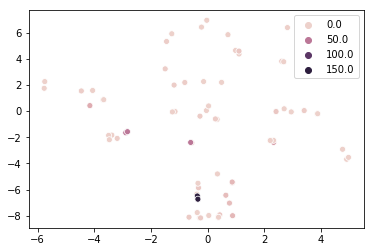

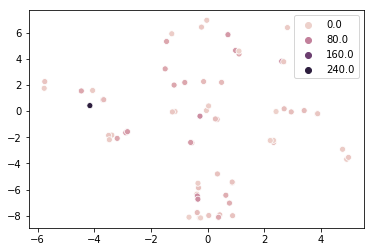

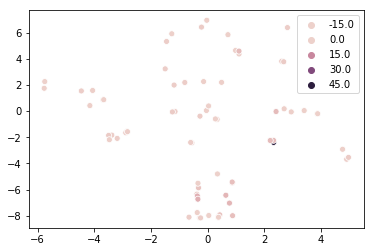

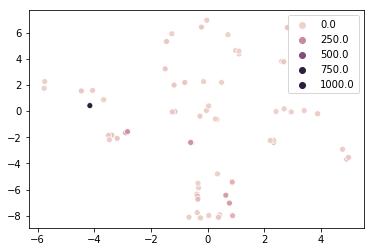

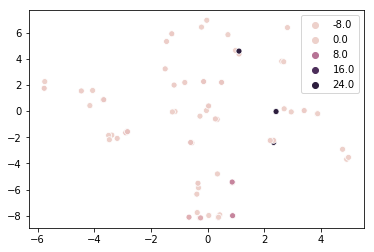

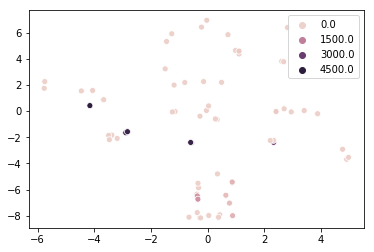

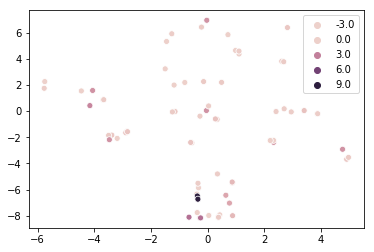

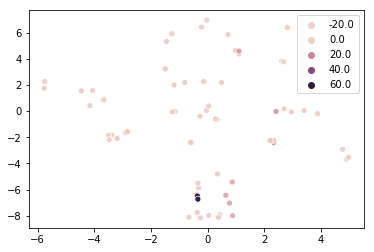

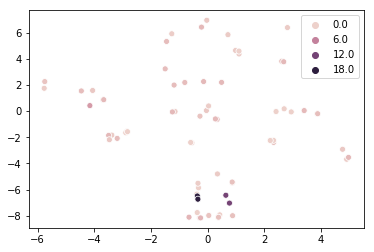

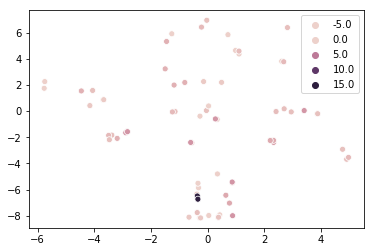

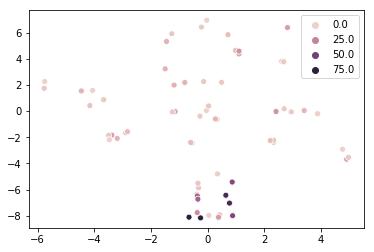

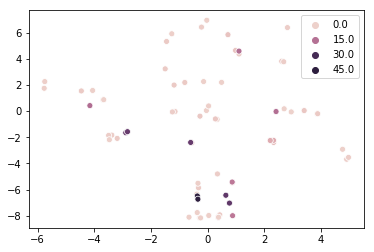

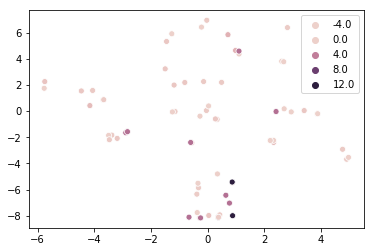

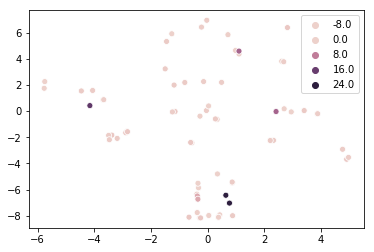

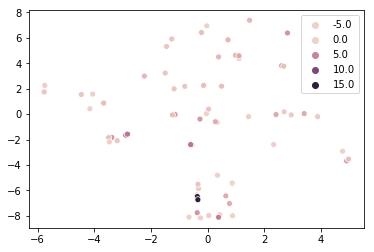

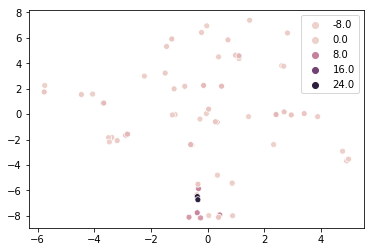

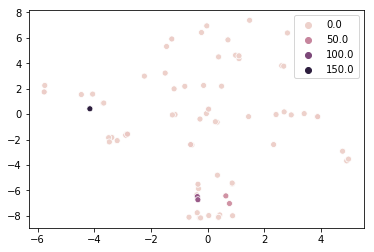

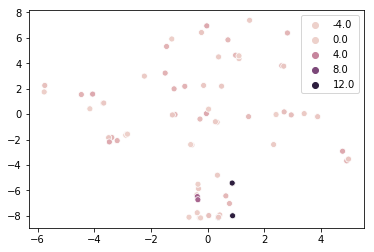

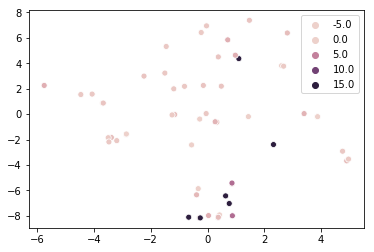

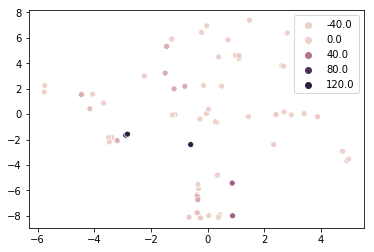

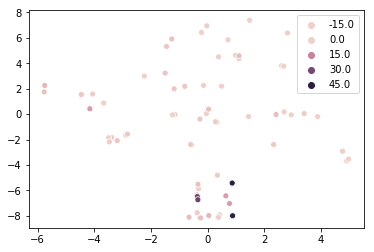

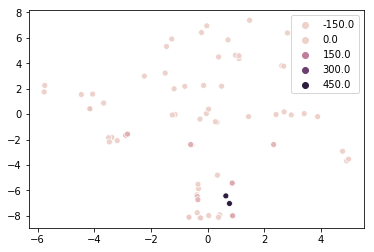

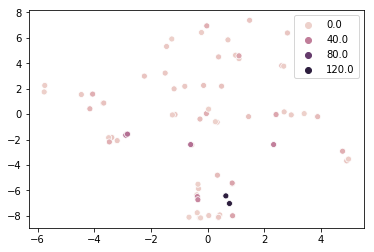

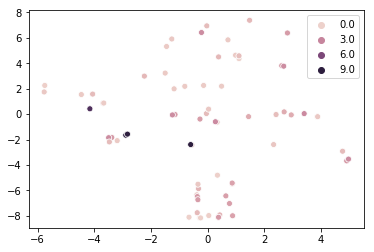

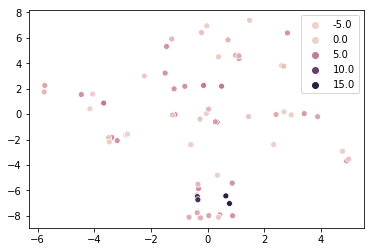

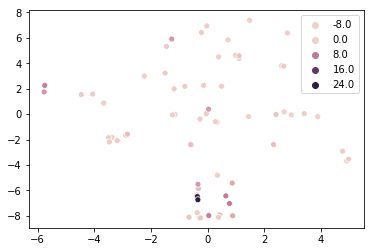

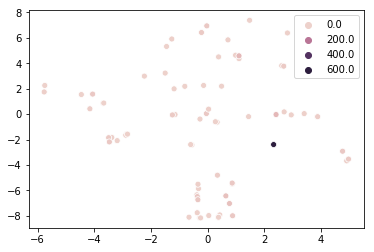

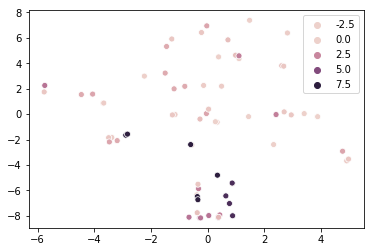

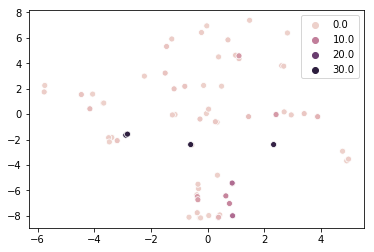

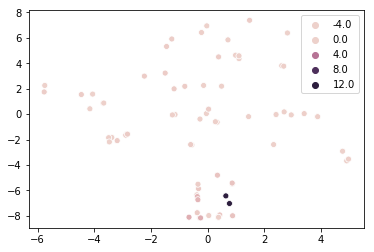

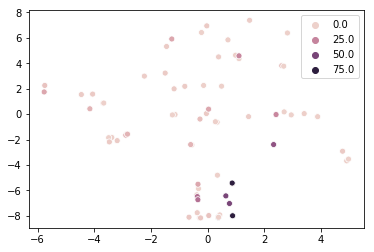

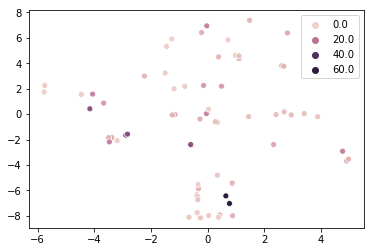

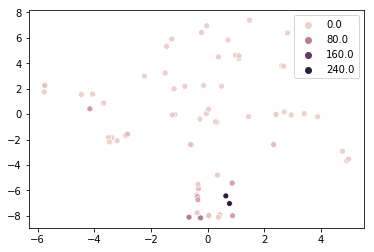

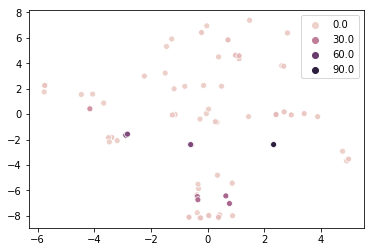

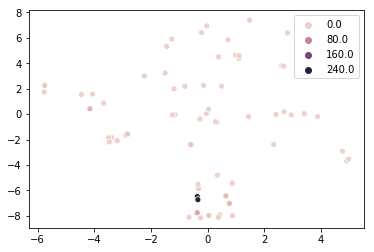

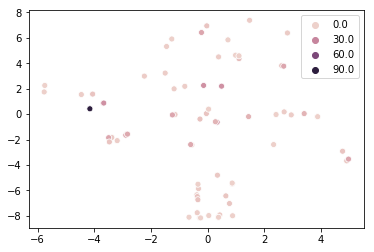

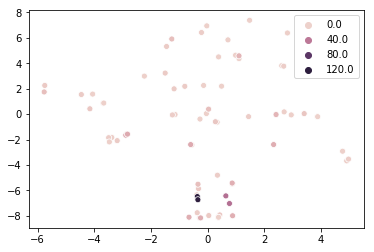

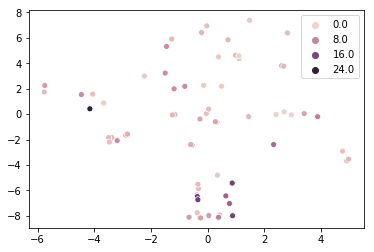

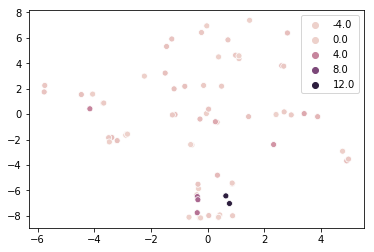

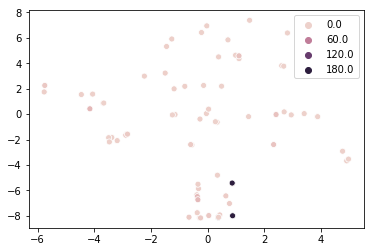

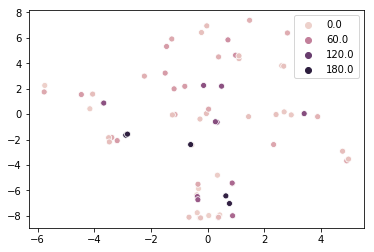

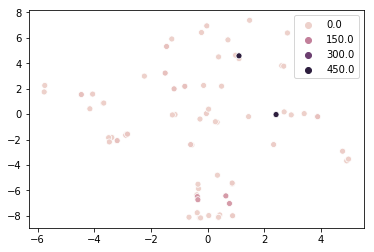

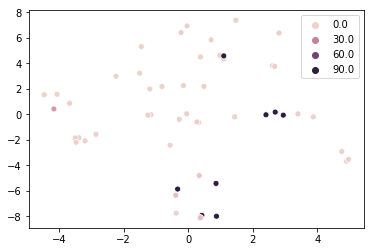

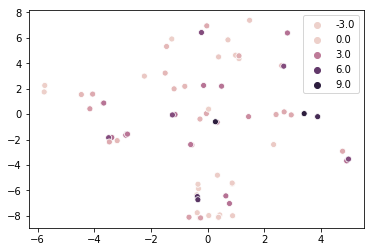

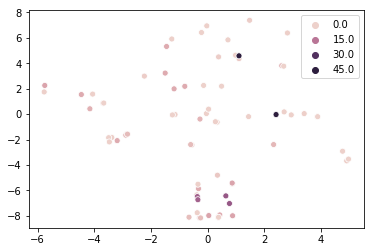

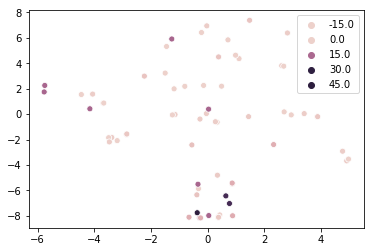

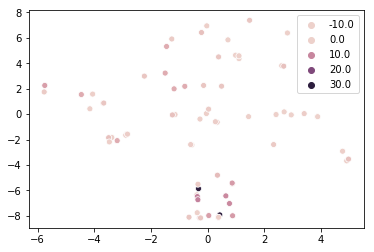

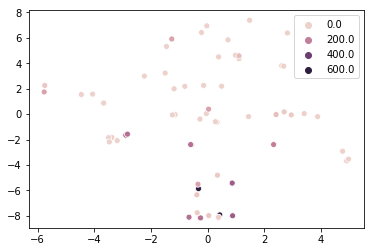

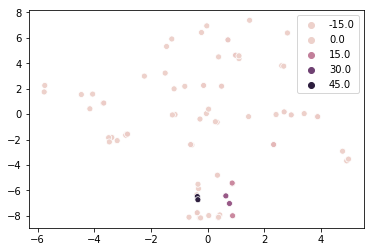

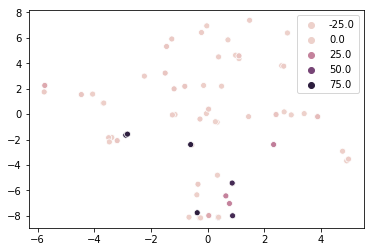

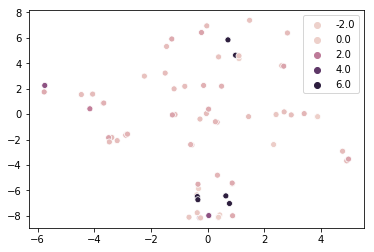

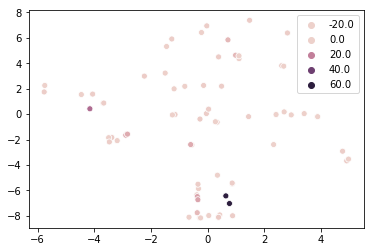

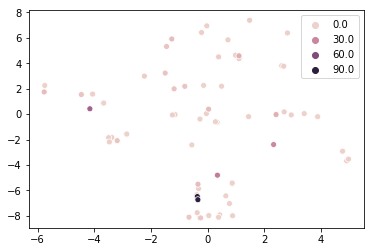

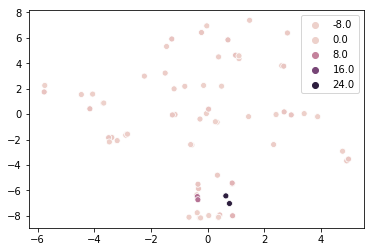

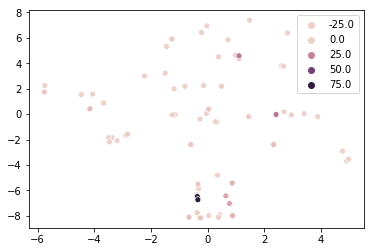

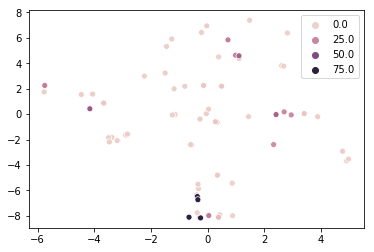

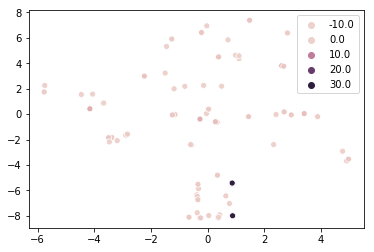

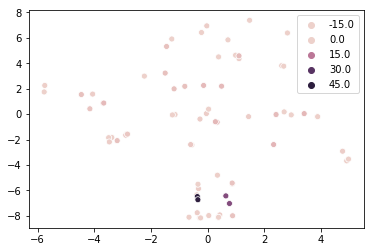

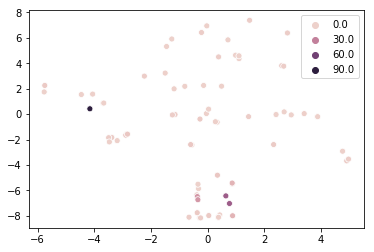

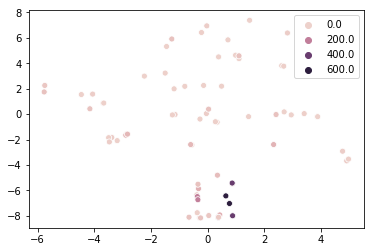

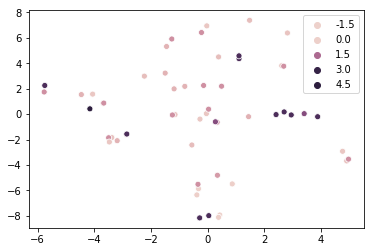

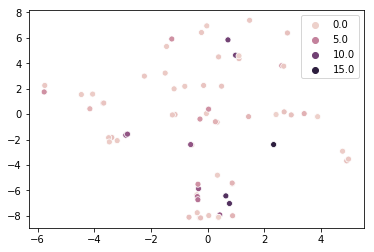

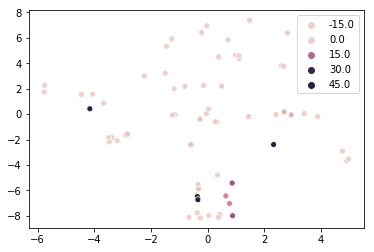

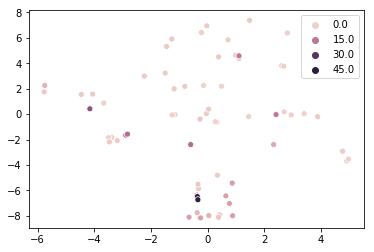

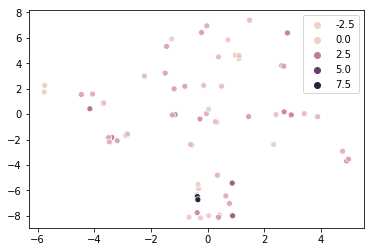

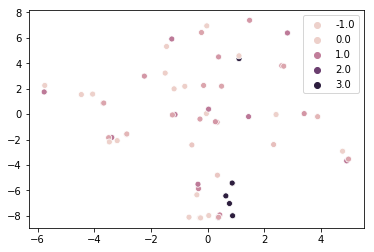

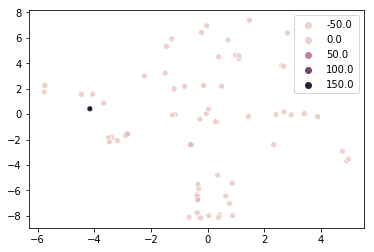

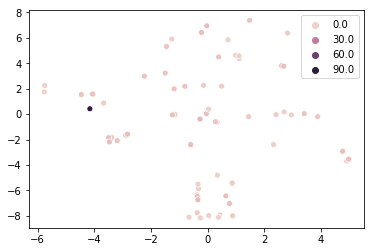

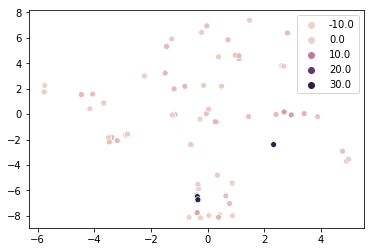

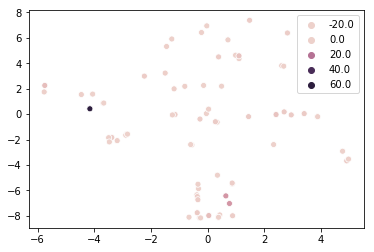

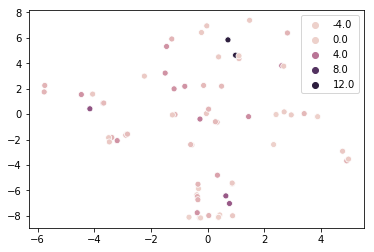

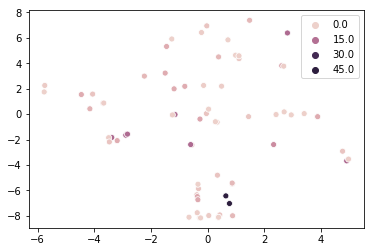

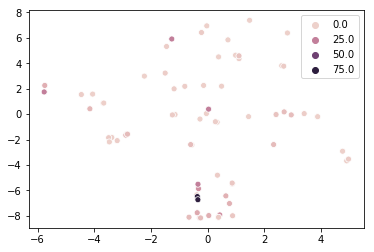

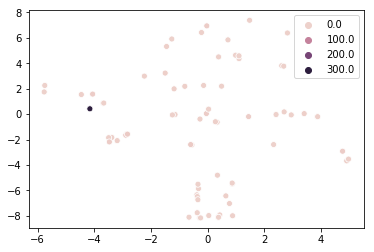

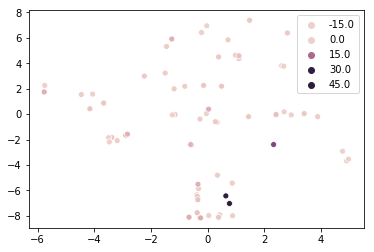

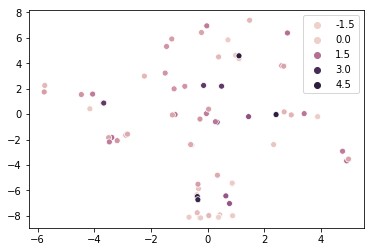

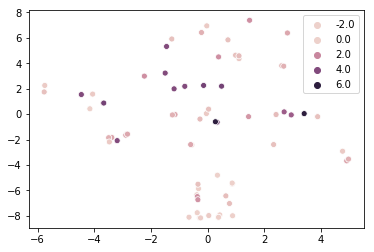

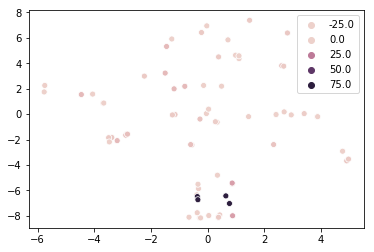

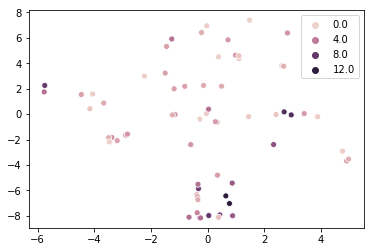

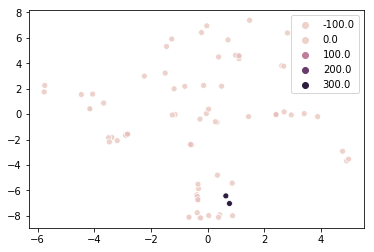

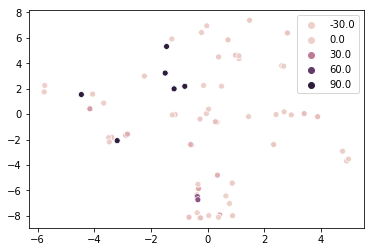

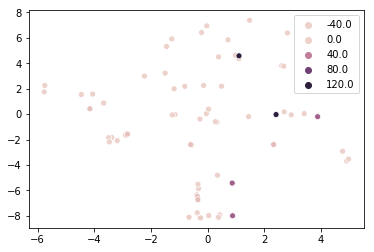

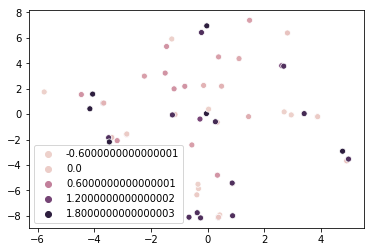

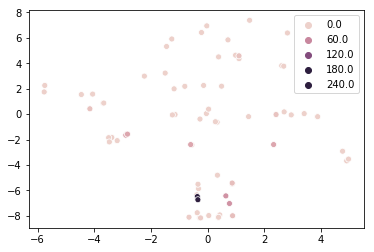

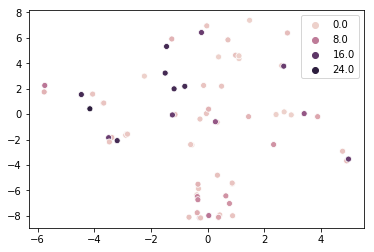

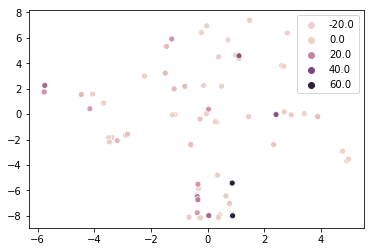

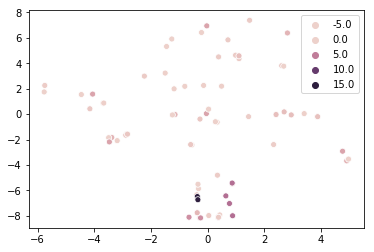

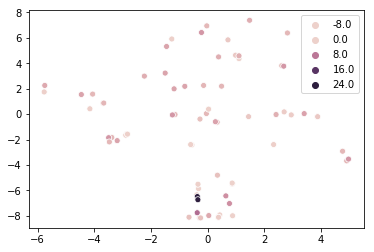

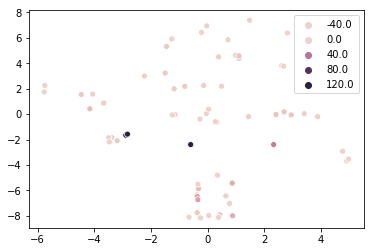

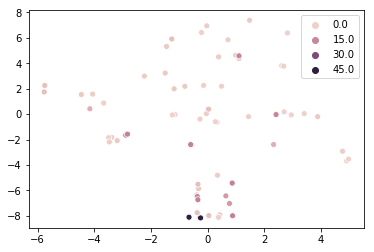

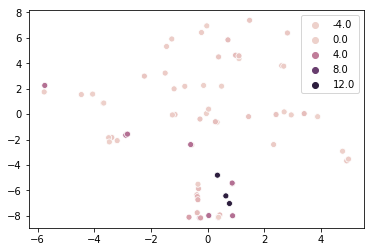

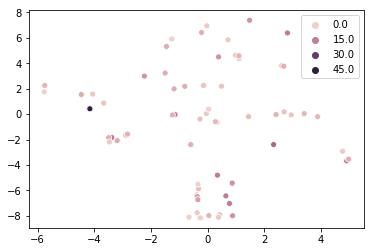

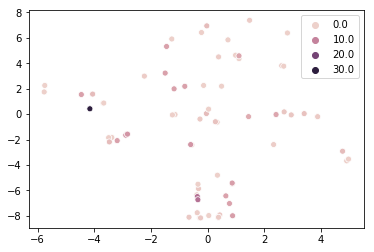

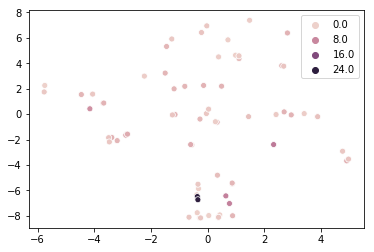

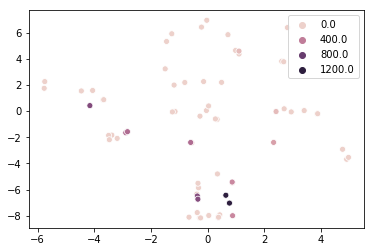

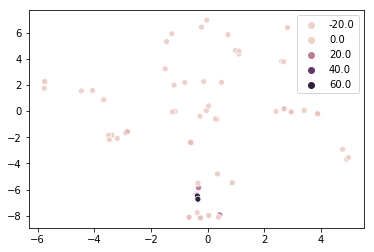

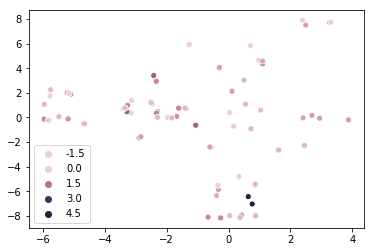

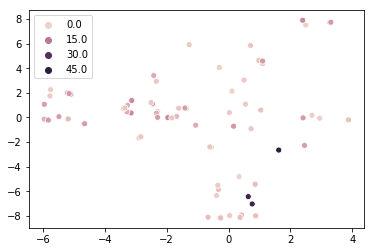

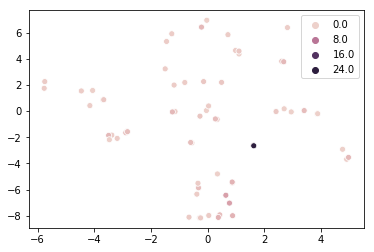

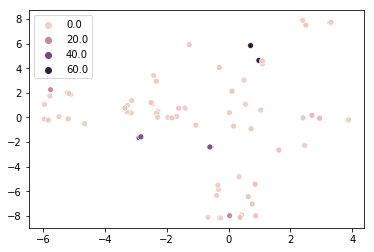

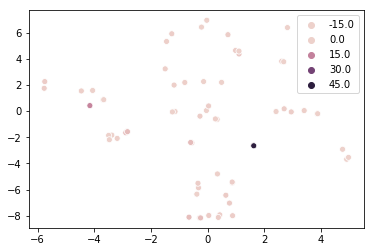

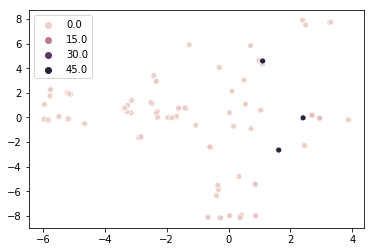

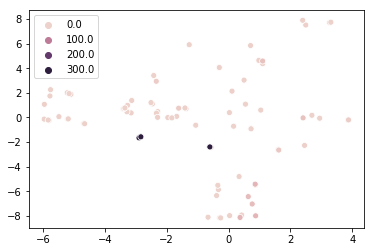

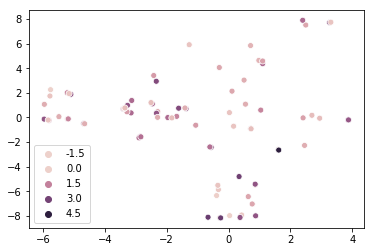

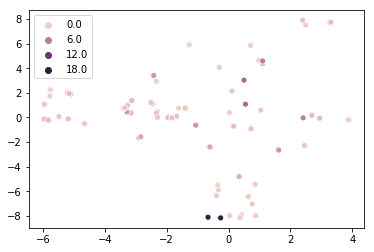

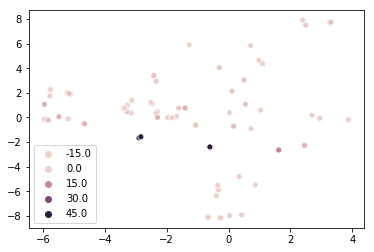

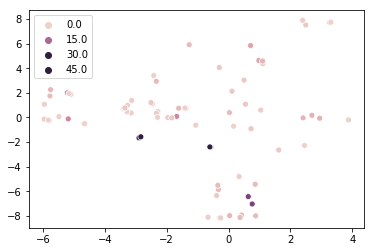

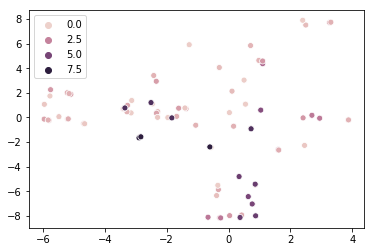

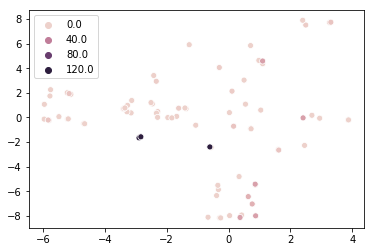

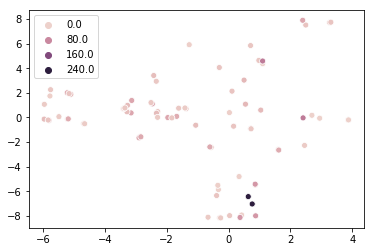

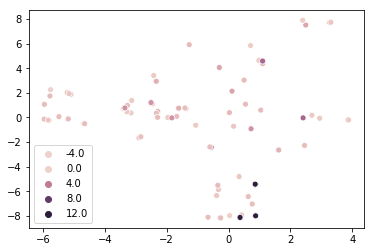

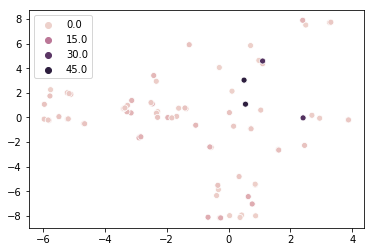

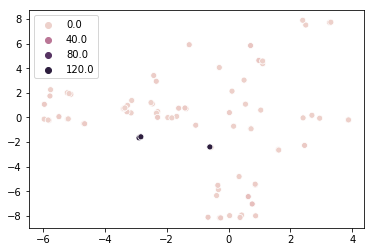

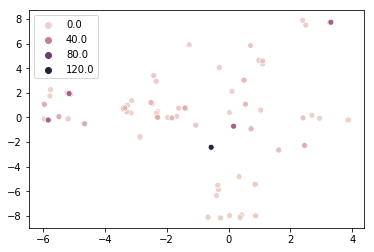

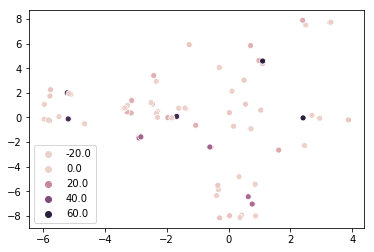

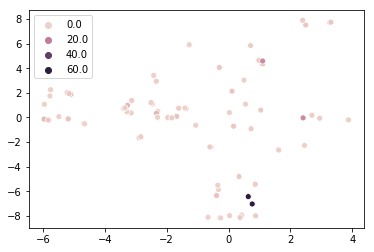

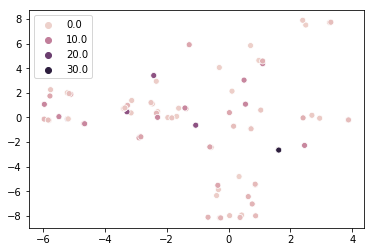

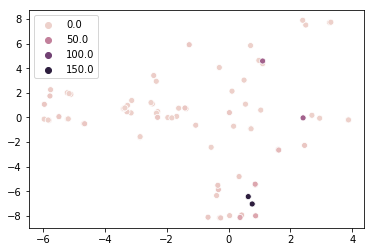

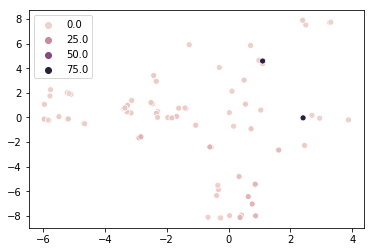

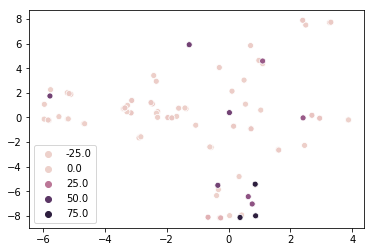

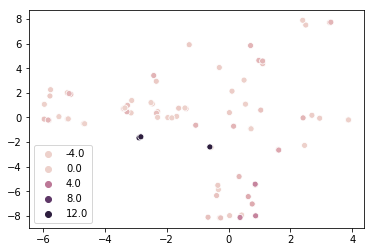

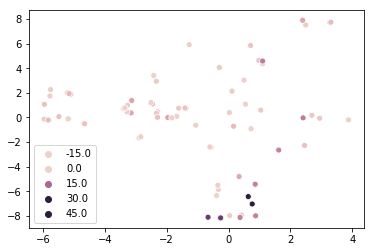

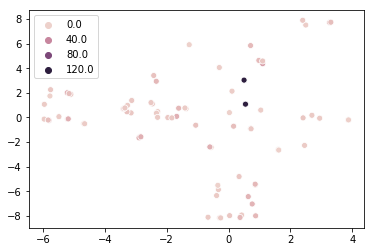

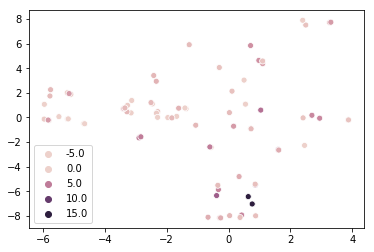

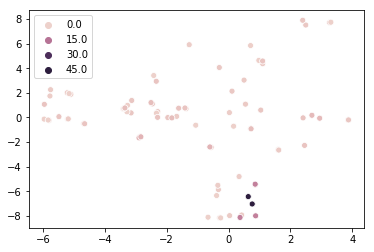

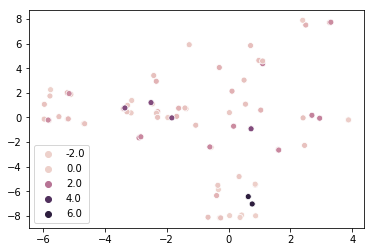

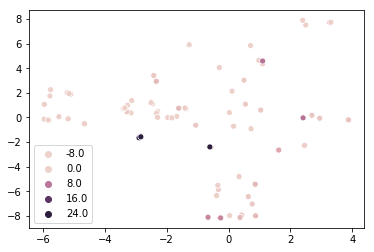

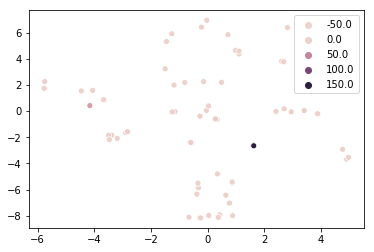

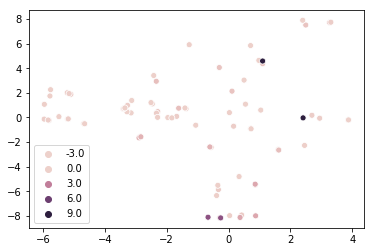

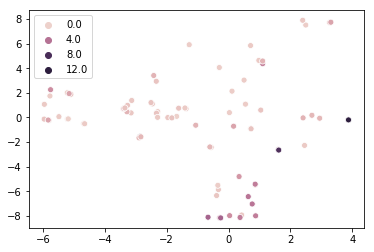

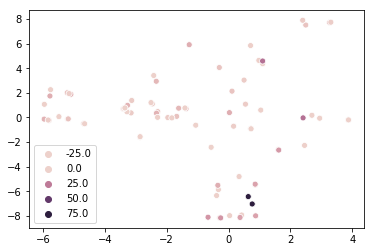

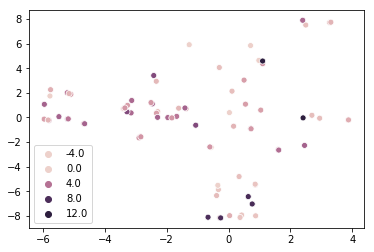

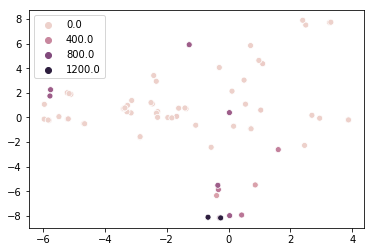

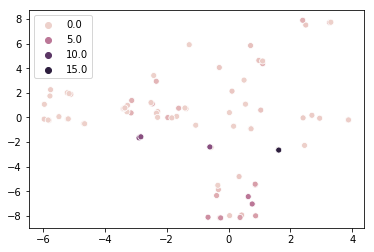

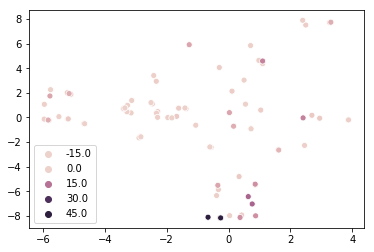

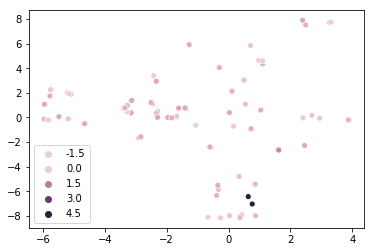

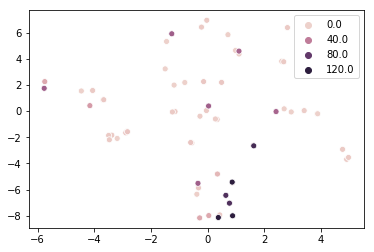

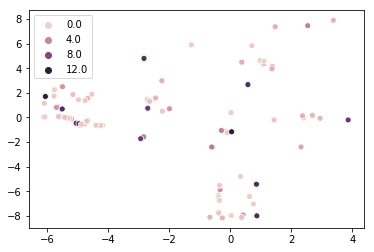

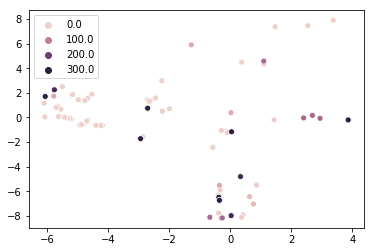

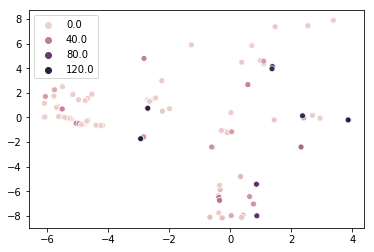

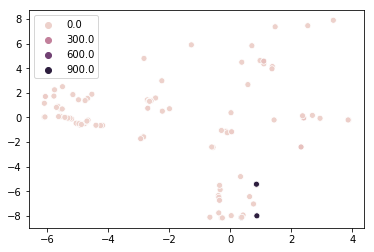

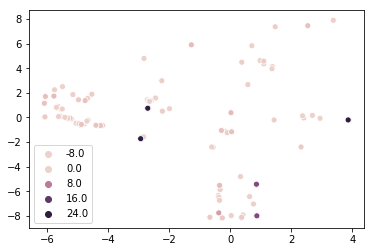

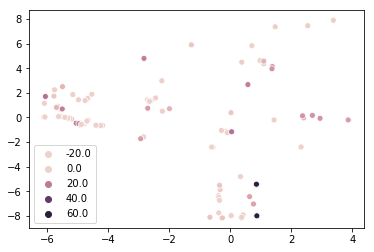

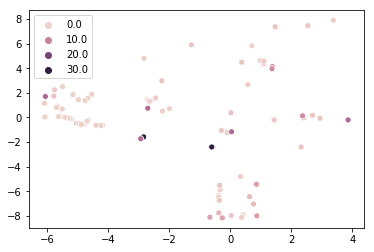

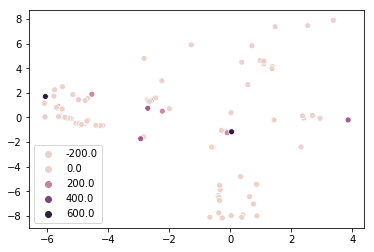

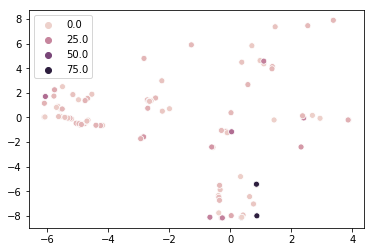

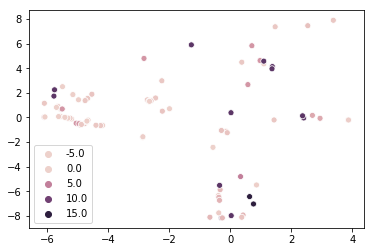

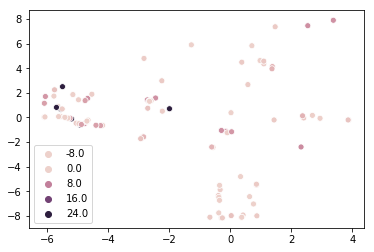

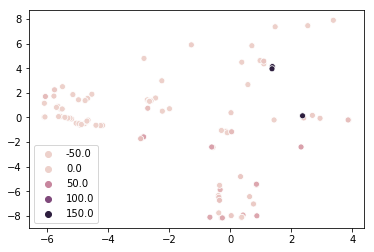

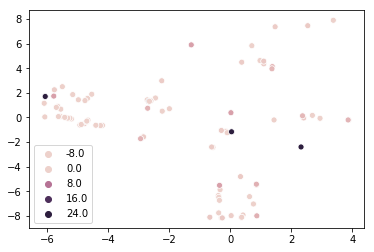

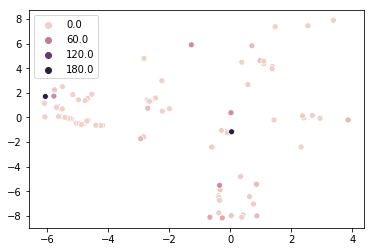

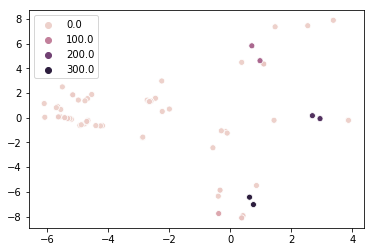

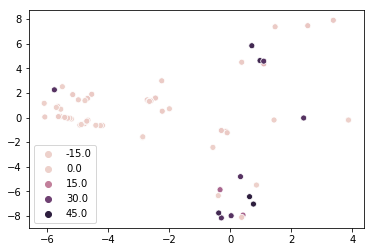

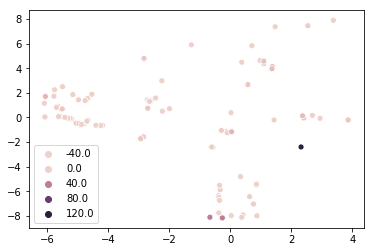

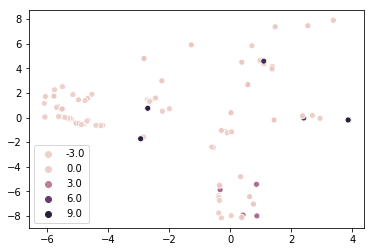

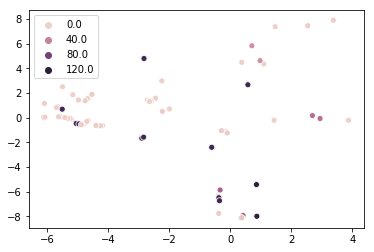

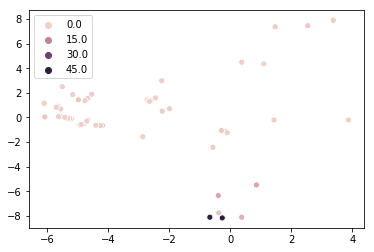

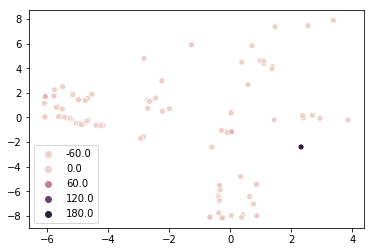

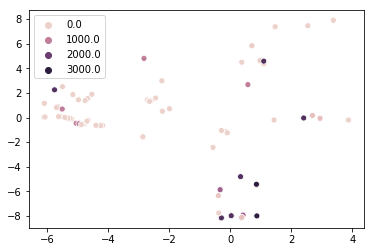

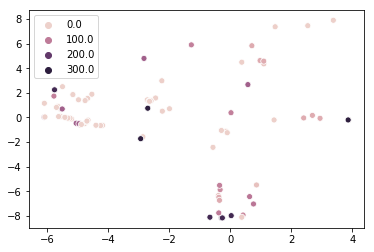

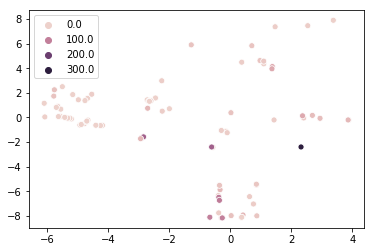

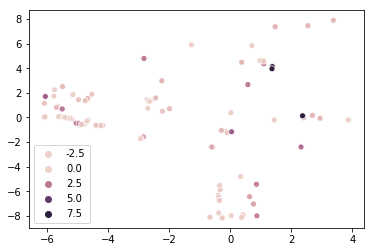

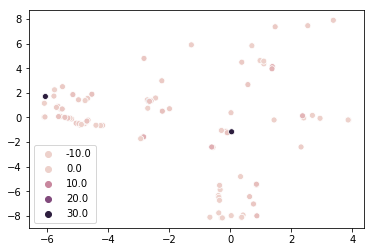

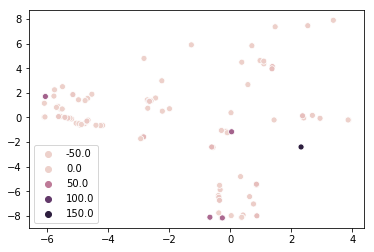

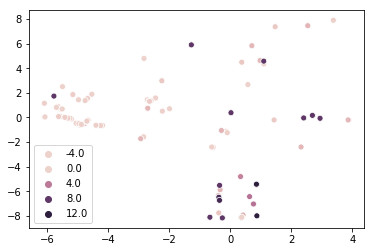

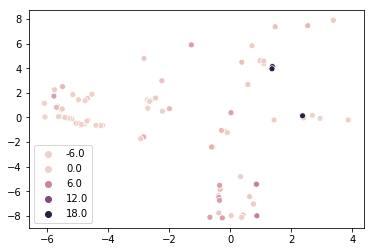

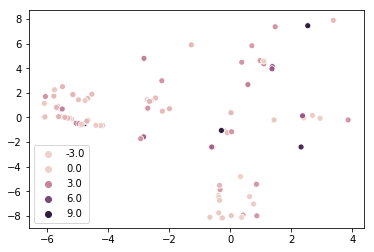

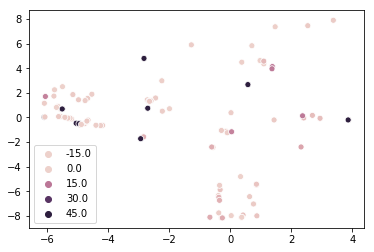

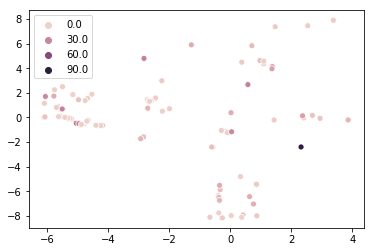

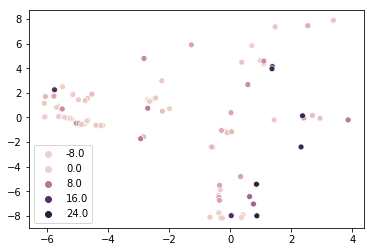

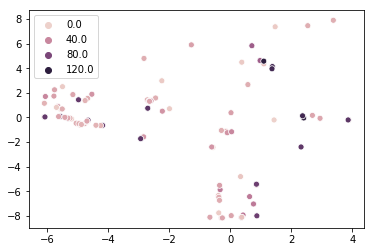

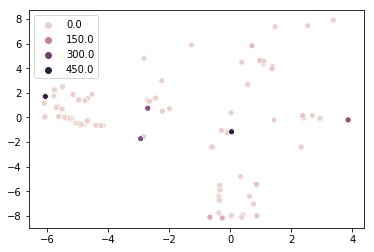

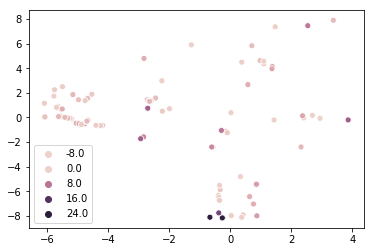

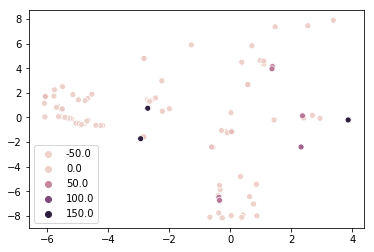

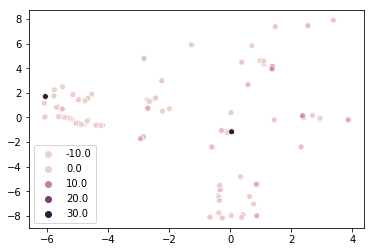

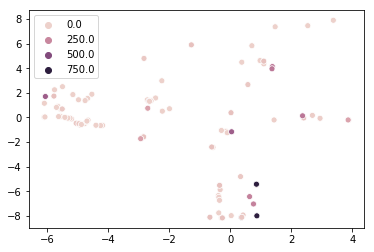

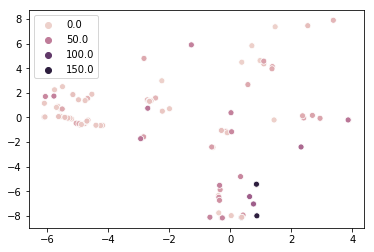

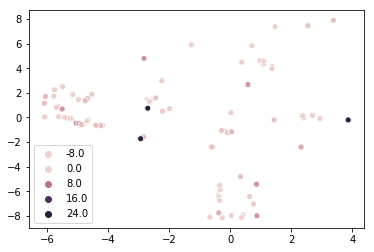

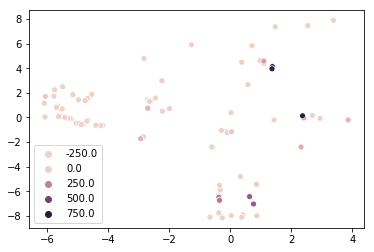

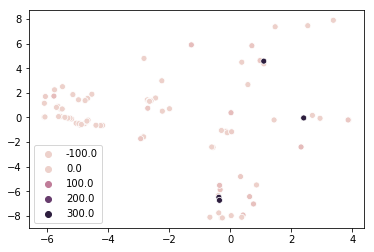

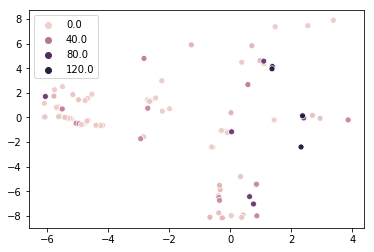

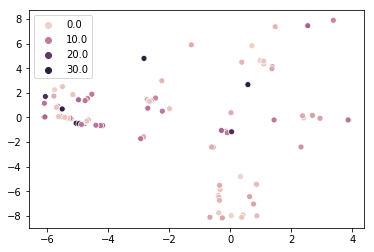

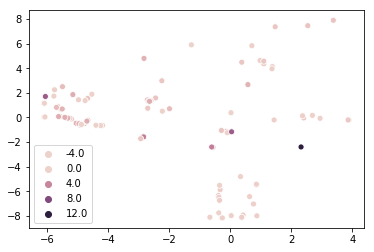

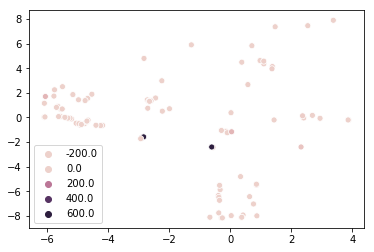

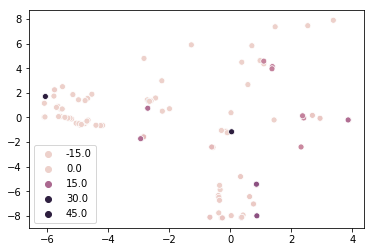

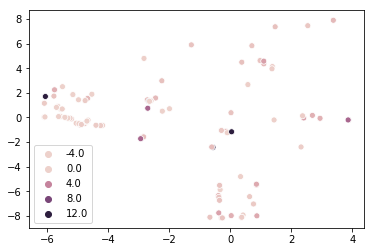

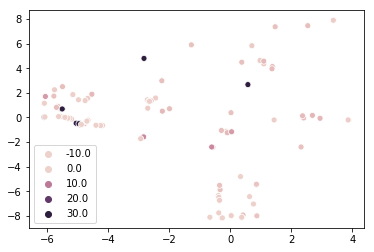

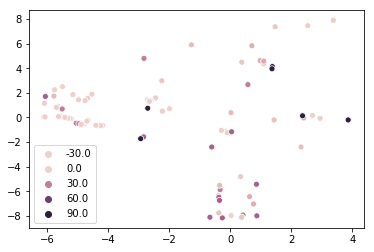

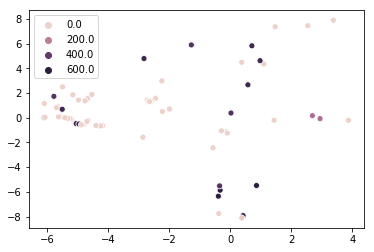

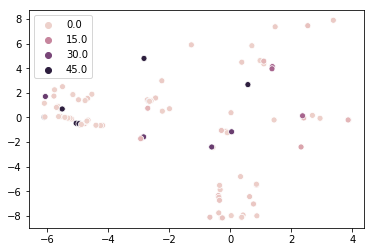

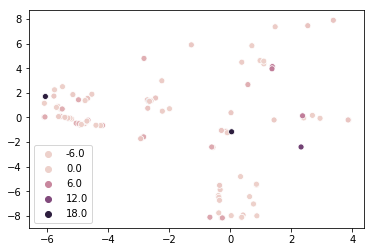

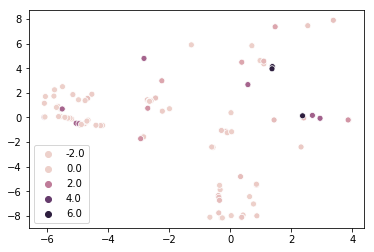

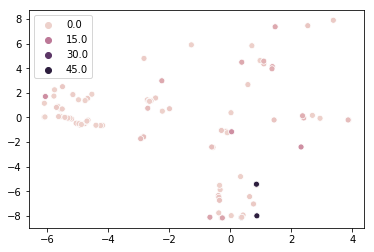

In [59]:
prefix = 'umap'
for src in np.unique(out_df.source):
    rows = out_df[out_df.source == src]
    rows = rows[rows.n > 5]
    if len(rows) == 0:
        continue
    # now plot rate against umap from audio
    x_y_sr = []
    KL_range = [rows.KL.min(), rows.KL.max()]
    print(KL_range)

    for ind,row in rows.iterrows():
        for stim in row.present_stims:
            x_y_sr.append([vocCategoryTable.at[stim,'%s1'%prefix],vocCategoryTable.at[stim,'%s2'%prefix], row.KL])
    x_y_sr = np.asarray(x_y_sr,dtype=float)
    plt.figure()
    seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,2])

In [336]:
rows

Empty DataFrame
Columns: [call_type, maxsr, n, present_stims, psth, rate, rate_std, stimname, t_start, source, source_rate, source_std, KL]
Index: []

### Reading the data 

In [224]:
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'
birdName = 'ZF4F'
siteName = 'ZF4F_2t_190611_160843'
electrode = '17'
elecnum = 9  # This is 17-8
cluster = 3    # This will go somewhere else or will be looped.

# Full Pathsf
#inPath = rootPath + dataPath + birdName + '/sites/' + siteName + '/goodPlayback-e' + electrode + '-c' + str(cluster) + '.pkl'
#inPath = "/auto/zdrive/lthomas/goodPlayback-e17-c3.pkl"
inPath = "/auto/zdrive/lthomas/goodpkls/birds/ZF4F/ZF4F_8_5t_190621_100019/goodPlayback-e10-c92.pkl"

In [225]:

fileIn = open(inPath, 'rb')
unitInfo = pk.load(fileIn)
dfAbsTime = pk.load(fileIn)
dfRelTime = pk.load(fileIn)
fileIn.close()

In [226]:
# only take data for times we know the call type
dfRelTime = dfRelTime[dfRelTime["call_type"].astype(bool)]

In [227]:
pdEphysAndStim = []

# now go through each playback and find the voc cuts present in the first 600 ms of each playback
for ind, row in dfRelTime.iterrows():
    sfn = row.file[:-10]
    # get segments associated with this stimulus
    segs = pdsegTable[pdsegTable['stimname'] == sfn]
    if len(segs)==0:
        continue
    
    #basically i will take all segments in the first 600 ms, if there are more segments, 
    # i will take another window starting at the next segment
    t_win = .5
    t_delay = .02
    t_start = np.min(segs.start)#0.0 #s
    

    
    while (segs['start'] >= t_start - t_delay).sum() > 0:
        # first take the s_win long PSTH window
        t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_start + t_win)
        psth = row.spikeKDE[t_inds]
        
        # then take all stim that are present in that window (shifted by t_delay)
        stim_inds = np.logical_and(segs['start'] >= t_start - t_delay, segs['start'] < t_start + t_win - t_delay)
        present_stims = np.array(segs.ind[stim_inds])
        
        #spikerate from spiketimes
        srs = [np.logical_and(sts >= t_start,sts < t_start + t_win).sum() for sts in row.spikeTimes]
        
        pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                               'psth': psth, 'present_stims':present_stims, 
                               'call_type': row.call_type, 'rate': np.mean(srs)})
        
        next_stim_inds = segs.start >= t_start + t_win - t_delay
        if next_stim_inds.sum() == 0:
            break
        t_start = np.min(segs.start[next_stim_inds])
        
pdStimSegTable = pandas.DataFrame(pdEphysAndStim)


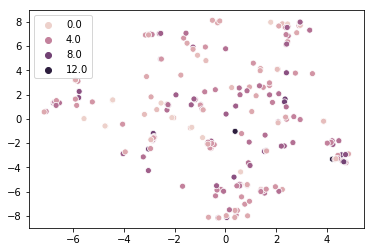

In [228]:
# now plot rate against umap from audio
x_y_sr = []
sr_range = [pdStimSegTable.rate.min(), pdStimSegTable.rate.max()]
for ind,row in pdStimSegTable.iterrows():
    for stim in row.present_stims:
        x_y_sr.append([vocCategoryTable.at[stim,'umap1'],vocCategoryTable.at[stim,'umap2'], row.rate])
x_y_sr = np.asarray(x_y_sr,dtype=float)
seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,2])

### Now we have pdStimSegTable with [stims present inds relativet o vocSelTable, psth, stimname, t_start]


-------------
ARI: 0.05065627769936454


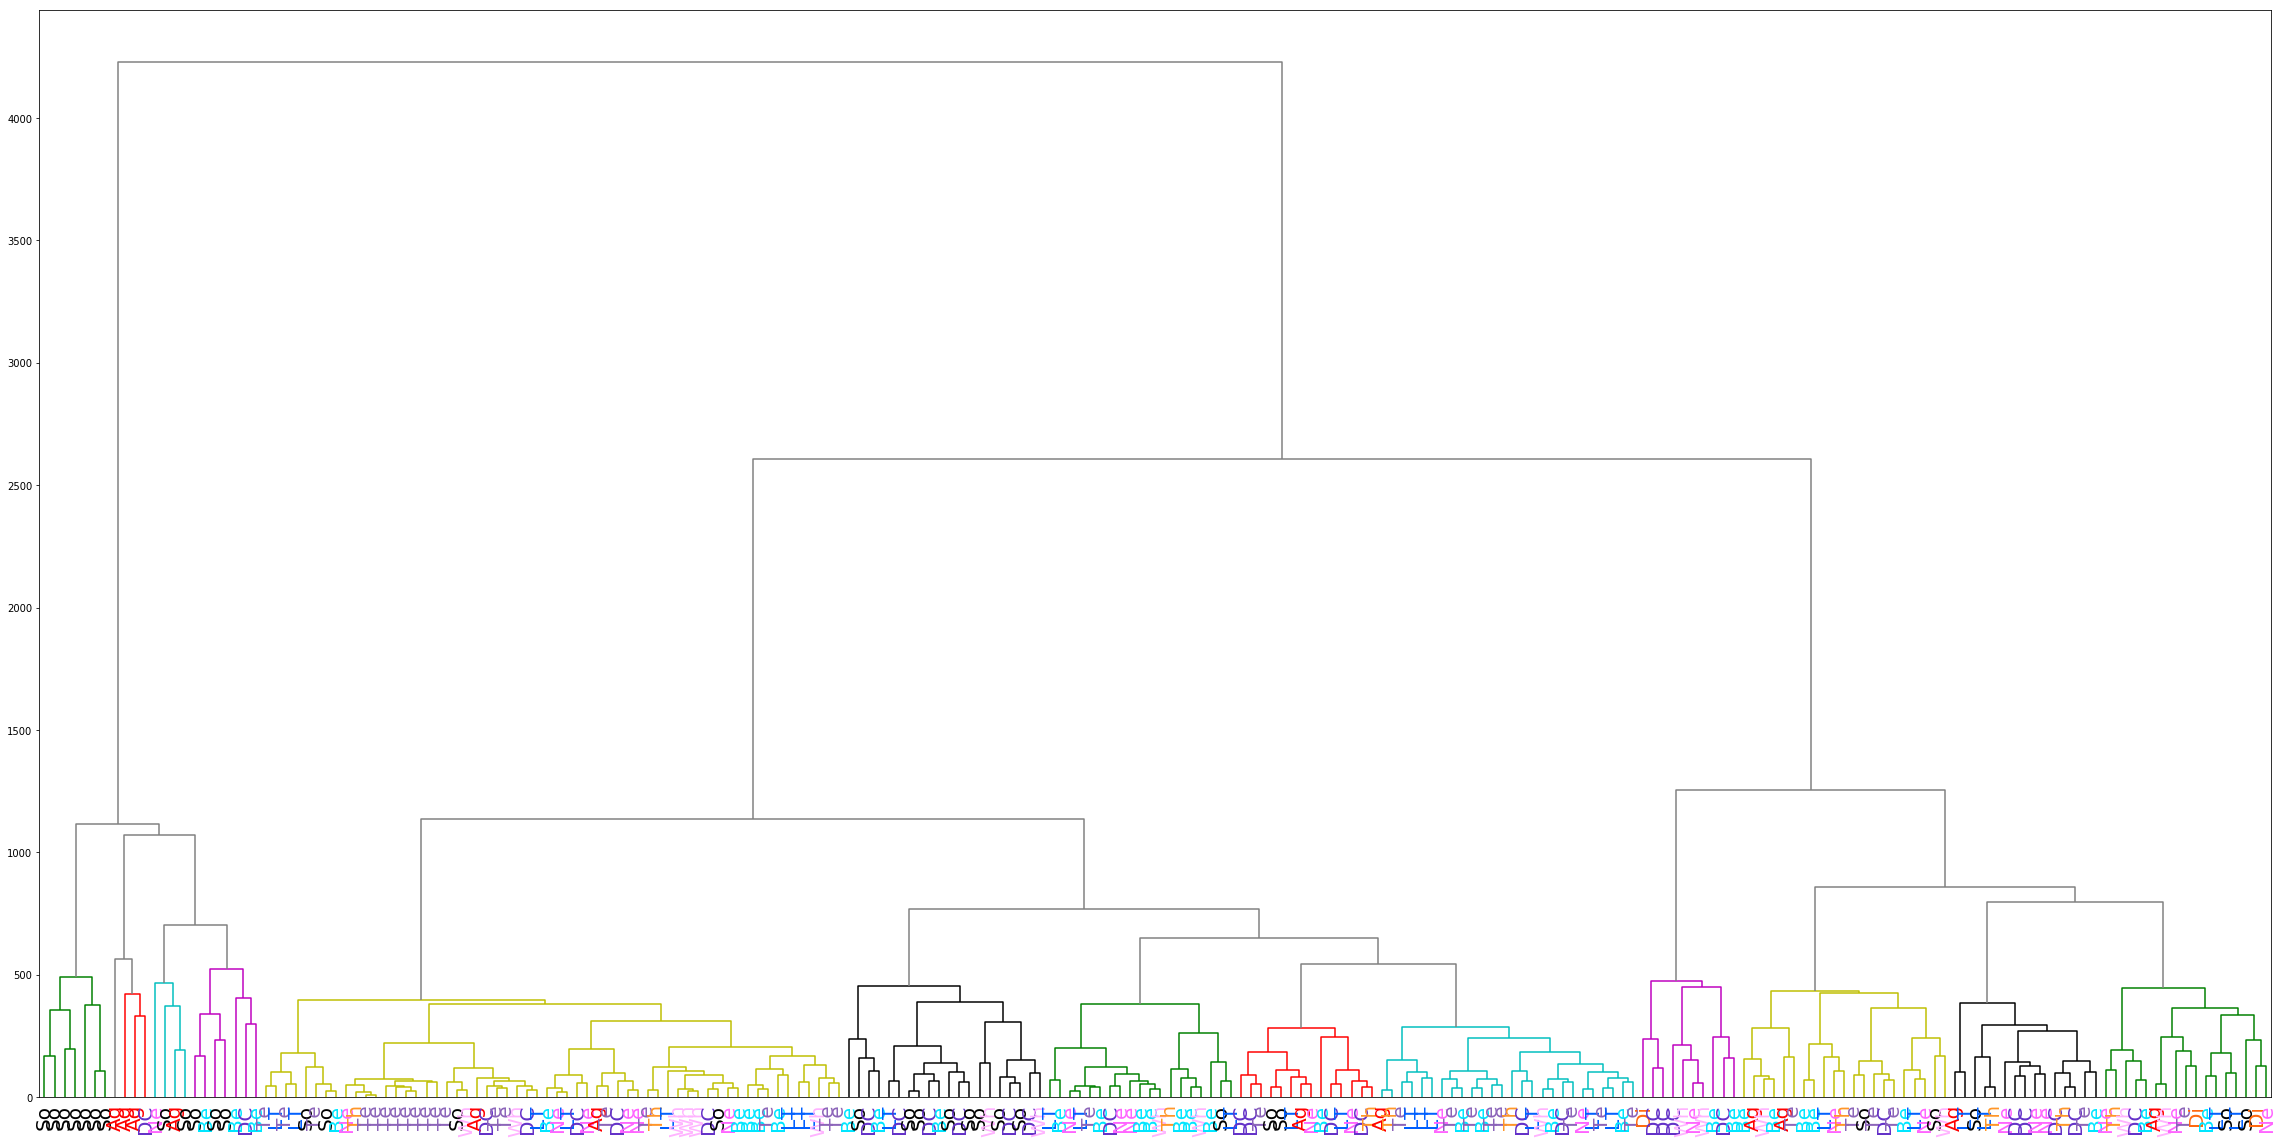

In [188]:
a,b,c,g = cluster_analysis(np.vstack(pdStimSegTable.psth),np.array(pdStimSegTable.call_type),and_plot=True)


In [185]:
dfRelTime.spikeTimes[0]

[array([-0.42668, -0.42284, -0.33552, -0.28276, -0.24132, -0.11088,
        -0.06688, -0.01544,  0.01532,  0.02528,  0.02804,  0.02968,
         0.0322 ,  0.0364 ,  0.0422 ,  0.04632,  0.0532 ,  0.05412,
         0.06376,  0.06768,  0.0748 ,  0.08304,  0.13944,  0.22884,
         0.23036,  0.23592,  0.2442 ,  0.2496 ,  0.2642 ,  0.26972,
         0.27812,  0.3012 ,  0.33012,  0.34984,  0.35728,  0.36408,
         0.36964,  0.40568,  0.44812,  0.4584 ,  0.49416,  0.52496,
         0.52916,  0.53164,  0.53916,  0.55532,  0.55756,  0.58488,
         0.59448,  0.63524,  0.64668,  0.64788,  0.6516 ,  0.672  ,
         0.68636,  0.73136,  0.7356 ,  0.74112,  0.74352,  0.77412,
         0.81048,  0.83664,  0.84972,  0.85824,  0.92864,  0.9622 ,
         0.9636 ,  0.9678 ,  1.01268,  1.01788,  1.01936,  1.02132,
         1.02508,  1.0578 ,  1.08732,  1.08932,  1.09092,  1.09108,
         1.09296,  1.09484,  1.09736,  1.10068,  1.108  ,  1.12128,
         1.12632,  1.16172,  1.23524,  1.24976, 

In [90]:
pdsegTable[pdsegTable['stimname'] == 'BlaBla0506_MAF_So_2']

Empty DataFrame
Columns: [end, ind, start, stimname, wav]
Index: []

In [81]:
pdsegTable[pdsegTable['stimname'] == 'BlaBla0506_MAF_Ag_2_fs25k.wav'.strip('_fs25k.wav')]

Empty DataFrame
Columns: [end, ind, start, stimname, wav]
Index: []

In [83]:
'BlaBla0506_MAF_Ag_2_fs25k.wav'.strip('_fs25k.wav') == 'BlaBla0506_MAF_Ag_2'

False

In [85]:
'BlaBla0506_MAF_Ag_2_fs25k.wav'[:-10]

'BlaBla0506_MAF_Ag_2'

In [99]:
dfRelTime['tStim'][0]

array([-0.5    , -0.49996, -0.49992, ...,  4.49988,  4.49992,  4.49996])

In [135]:
sel_rows

Bird           F1           F2           F3 calltype    cvfund  \
7311  WhiLbl0010  1796.197661  3555.966850  4924.644625       So  0.257331   
7312  WhiLbl0010  1904.553675  3254.184972  4882.424213       So  0.023895   
7313  WhiLbl0010  1745.100788  3518.701454  5006.454671       So  0.171475   
7314  WhiLbl0010  2364.276332  3637.143945  5129.725709       So  0.074139   
7316  WhiLbl0010  1581.961892  3555.987693  5012.136589       So  0.344746   
7317  WhiLbl0010  1658.570670  3230.212441  4688.531864       So  0.292408   
7318  WhiLbl0010  2272.016928  3691.601189  5072.264815       So  0.340199   
7319  WhiLbl0010  2130.160022  3535.688762  4779.267492       So  0.068770   
7320  WhiLbl0010  1479.615812  3234.550209  4822.218716       So  0.350994   
7321  WhiLbl0010  1750.411579  3443.706588  4705.861006       So  0.126746   
7323  WhiLbl0010  2297.479036  3675.924683  4915.438248       So  0.130204   
7324  WhiLbl0010  1632.700224  3102.982967  4523.923164       So  0.299983   
7327  WhiLbl0010  2448.883309  3698.714027  5003.178602       So  0.205674   
7332  WhiLbl0010  2135.214899  3829.288971  5005.226132       So  0.105041   

      duration      entS      entT                   filename  ...  \
7311  2.639116  0.685198  0.744730  WhiLbl0010_110601-Song-08  ...   
7312  2.639116  0.667324  0.751668  WhiLbl0010_110601-Song-08  ...   
7313  2.639116  0.812211  0.861853  WhiLbl0010_110601-Song-08  ...   
7314  2.639116  0.513105  0.768334  WhiLbl0010_110601-Song-08  ...   
7316  2.639116  0.828959  0.928237  WhiLbl0010_110601-Song-08  ...   
7317  2.639116  0.806847  0.769727  WhiLbl0010_110601-Song-08  ...   
7318  2.639116  0.751229  0.863410  WhiLbl0010_110601-Song-08  ...   
7319  2.639116  0.766087  0.781247  WhiLbl0010_110601-Song-08  ...   
7320  2.639116  0.804013  0.781513  WhiLbl0010_110601-Song-08  ...   
7321  2.639116  0.614768  0.738302  WhiLbl0010_110601-Song-08  ...   
7323  2.639116  0.736684  0.791683  WhiLbl0010_110601-Song-08  ...   
7324  2.639116  0.713462  0.745141  WhiLbl0010_110601-Song-08  ...   
7327  2.639116  0.492133  0.770253  WhiLbl0010_110601-Song-08  ...   
7332  2.639116  0.711876  0.938699  WhiLbl0010_110601-Song-08  ...   

               q1           q2           q3       rms       sal  samplerate  \
7311  2971.582031  3186.914062  4694.238281  0.023743  0.643818       44100   
7312  1894.921875  2368.652344  2842.382812  0.008949  0.609884       44100   
7313  2325.585938  2928.515625  3703.710938  0.015697  0.490716       44100   
7314  3359.179688  3703.710938  3746.777344  0.071774  0.740074       44100   
7316  1033.593750  2325.585938  3660.644531  0.007333  0.559740       44100   
7317  1937.988281  2627.050781  3617.578125  0.010137  0.575682       44100   
7318  2971.582031  3143.847656  3789.843750  0.026927  0.599535       44100   
7319  2670.117188  3014.648438  3703.710938  0.018157  0.442086       44100   
7320  1291.992188  2153.320312  3143.847656  0.011115  0.492239       44100   
7321  3100.781250  3531.445312  4694.238281  0.029433  0.657580       44100   
7323  2971.582031  3143.847656  3789.843750  0.038224  0.444223       44100   
7324  1894.921875  2368.652344  3531.445312  0.009340  0.632394       44100   
7327  3660.644531  3703.710938  3746.777344  0.075872  0.774052       44100   
7332  3100.781250  3574.511719  4306.640625  0.045777  0.833960       44100   

         skewS     skewT         stdS      stdT  
7311  0.178200 -0.384823  1412.631292  0.017269  
7312  1.234154  0.197557  1162.237305  0.018036  
7313  0.776944 -0.392596  1339.052134  0.035528  
7314  2.045889 -0.081256   857.570559  0.019968  
7316  1.583859 -0.522460  2248.203078  0.085256  
7317  1.289593  0.105616  1583.188969  0.019420  
7318  1.247729  1.252578  1066.928964  0.049352  
7319  0.630281 -0.057139  1107.402442  0.021721  
7320  1.566109  0.060771  1632.879674  0.021155  
7321 -0.341202 -0.379878  1108.582373  0.016899  
7323  0.599647  0.159317   948.833483  0.022531  
7324

# scrap below here

In [5]:
t_inds = np.logical_and(dfRelTime['tKDE'][0] >= -.1,dfRelTime['tKDE'][0] < .6)
PSTH_KDES_first_600 = np.zeros((len(dfRelTime),sum(t_inds)))
for i in range(len(dfRelTime)):
    PSTH_KDES_first_600[i,:] = dfRelTime['spikeKDE'][i][t_inds]

ERROR: Could not find a version that satisfies the requirement suss (from versions: none)
ERROR: No matching distribution found for suss
You should consider upgrading via the '/auto/fhome/lthomas/.virtualenvs/py3_env/bin/python3 -m pip install --upgrade pip' command.


-------------
0.054125435098651135
-------------


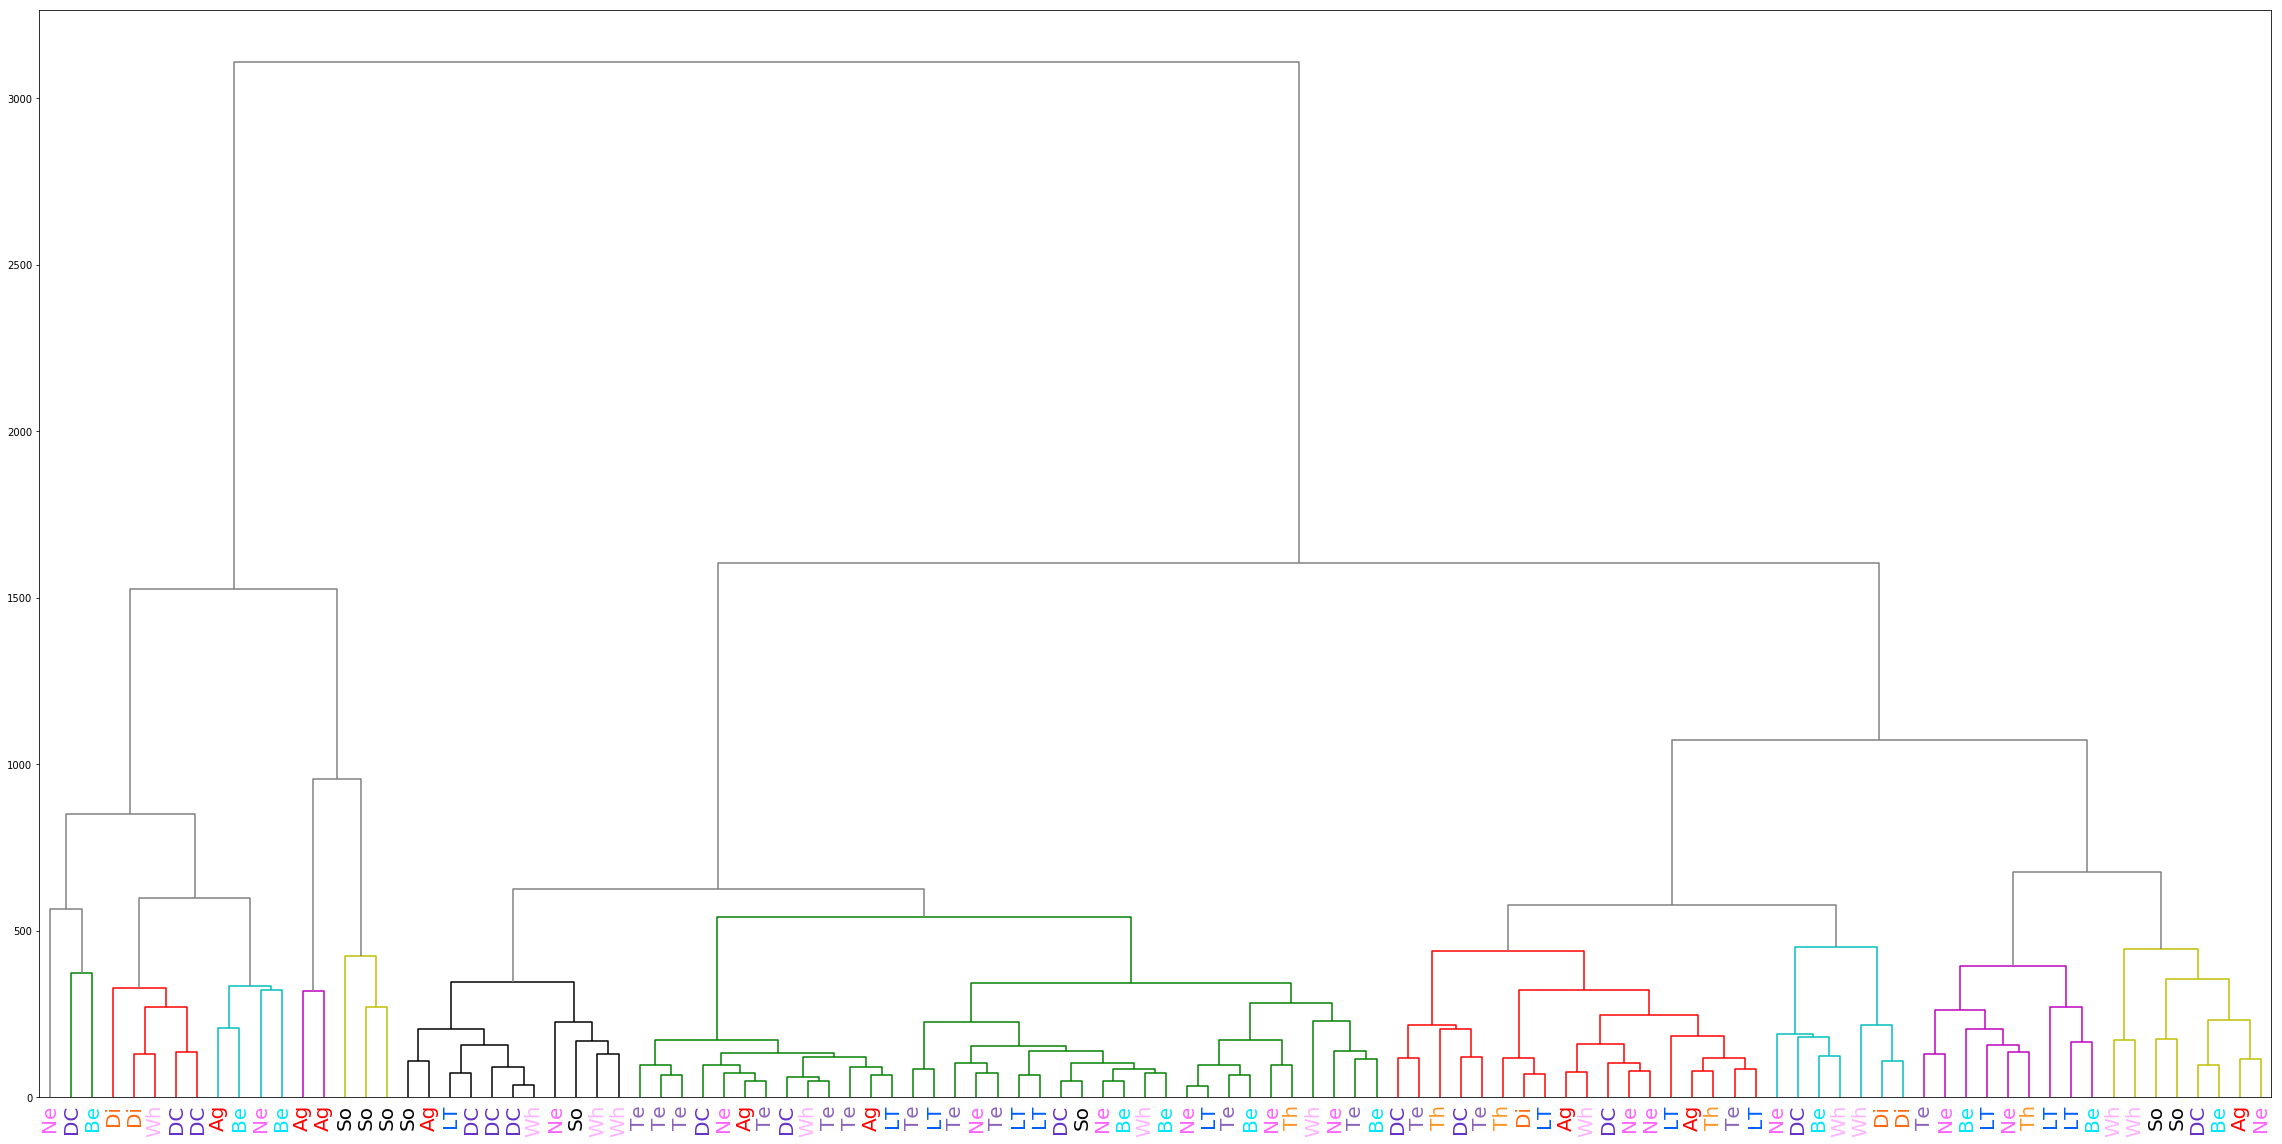

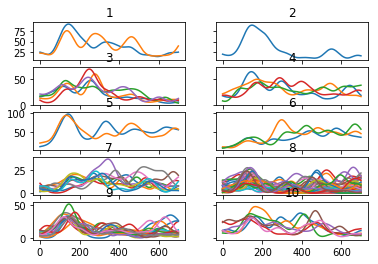

In [6]:
F,ari = cluster_analysis(PSTH_KDES_first_600,dfRelTime['call_type'][:],and_plot=True)
plot_grouping(PSTH_KDES_first_600,F)

-------------
0.07640190771175978
-------------


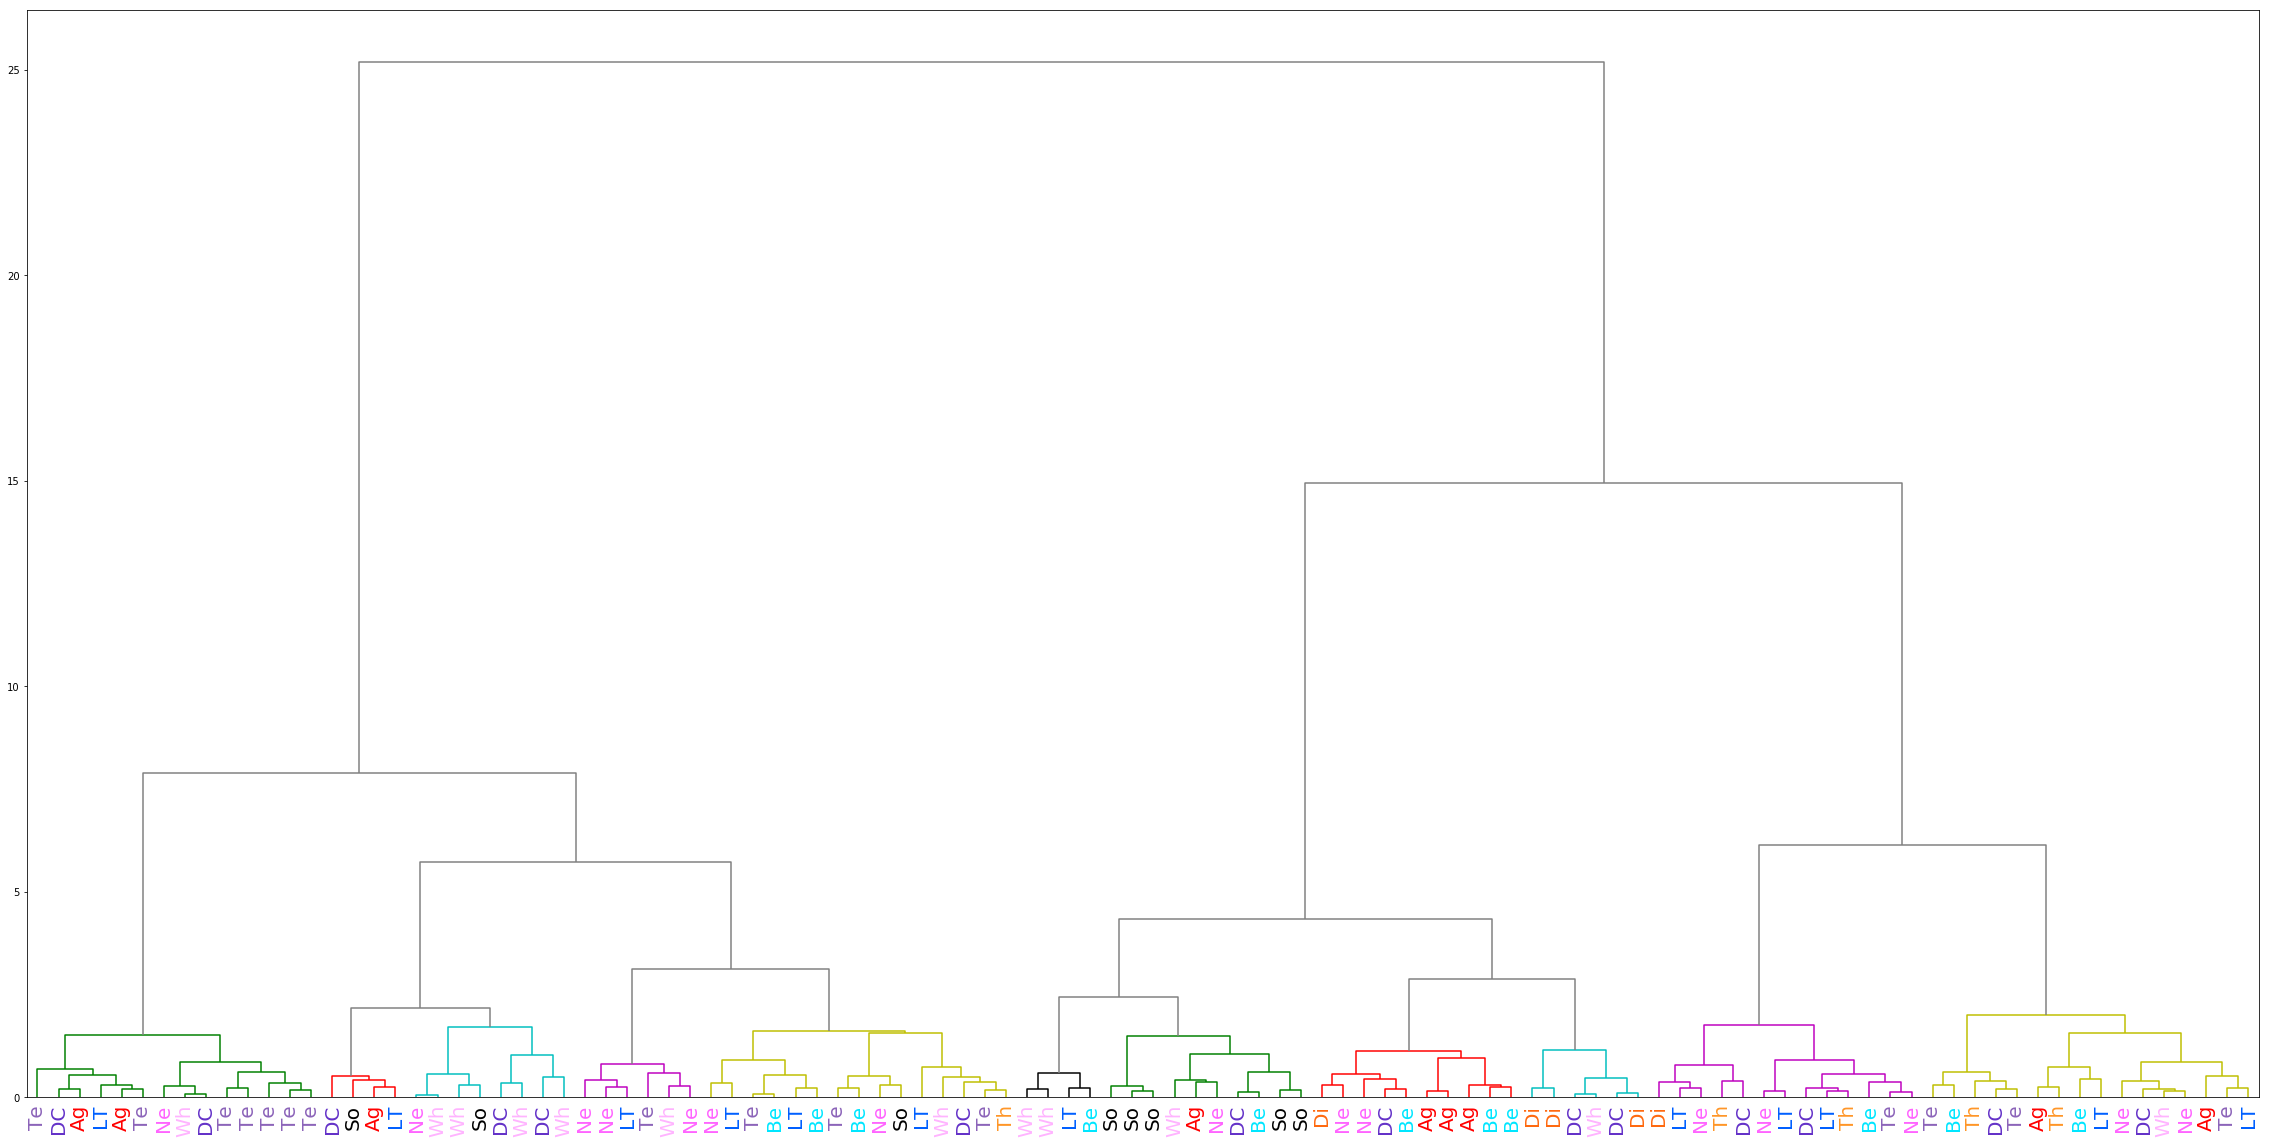

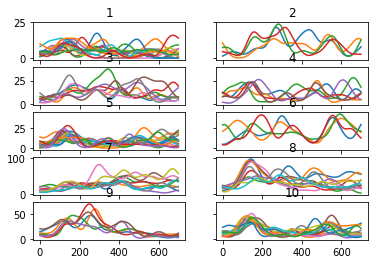

In [7]:
F,ari = cluster_analysis(PSTH_KDES_first_600[:,:],dfRelTime['call_type'][:],and_plot=True,use_umap=True)
plot_grouping(PSTH_KDES_first_600[:,:],F)

## FFT clustering

-------------
0.023036480127209186
-------------


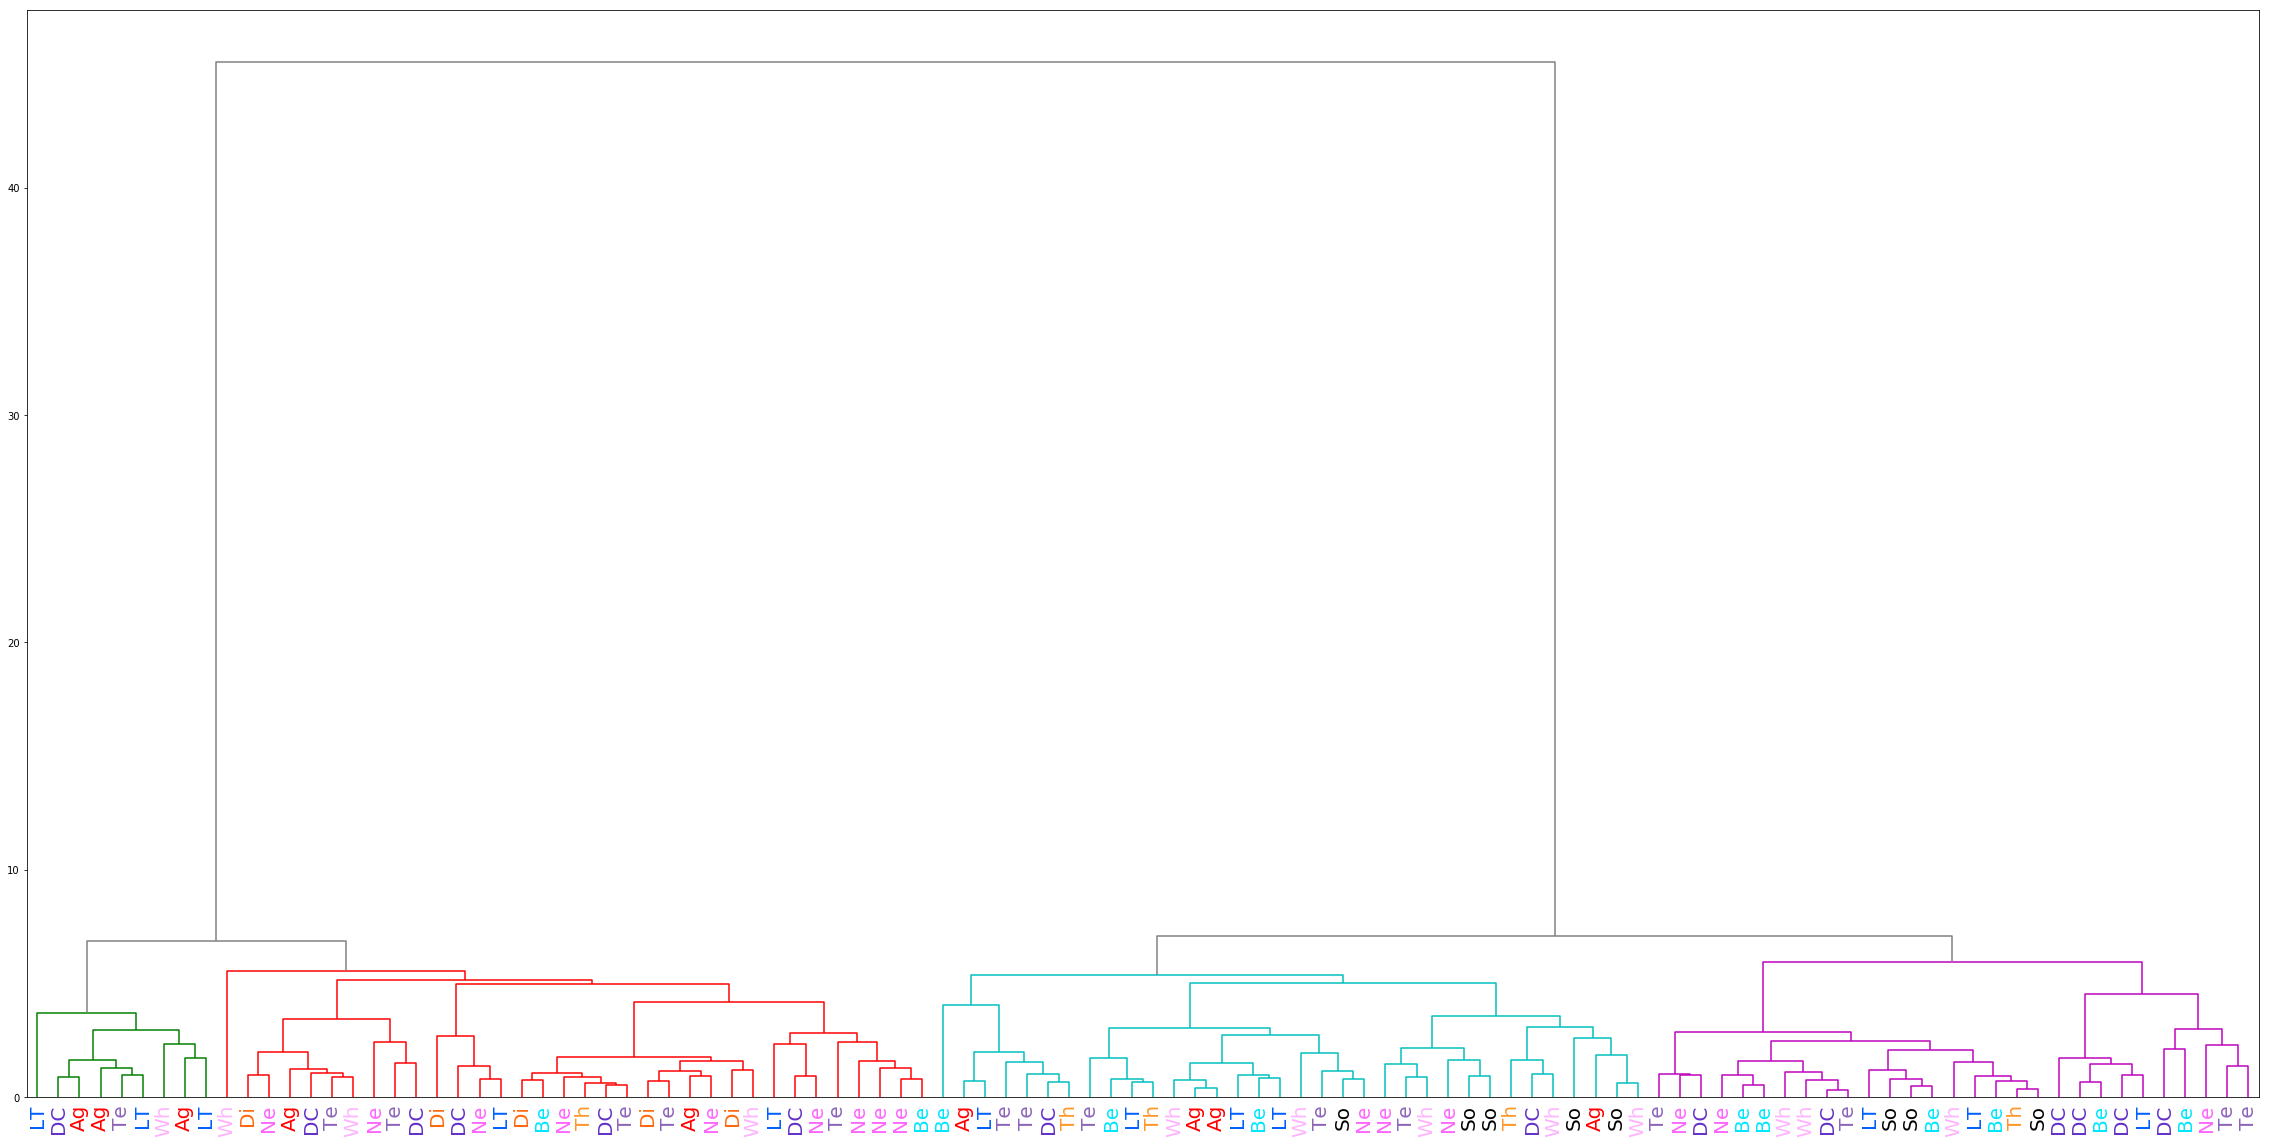

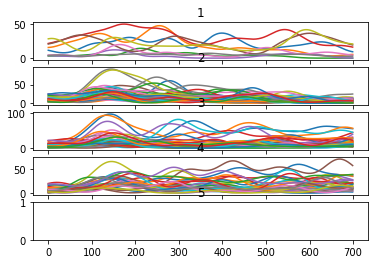

In [8]:
# lets do clustering on FFT
FFT_PSTH_KDES = np.fft.fft(PSTH_KDES_first_600[:,:])
npts = len(FFT_PSTH_KDES[0,:])
mag = np.abs(FFT_PSTH_KDES)[:,:50]
mag = mag/mag.max()
phase = np.angle(FFT_PSTH_KDES)[:,:50]
phase = phase/phase.max()
AMP_ANGLE = np.append(mag,phase,1)

F,ari = cluster_analysis(AMP_ANGLE,dfRelTime['call_type'][:],and_plot=True)
plot_grouping(PSTH_KDES_first_600,F)

/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


-------------
0.028284971816605654
-------------


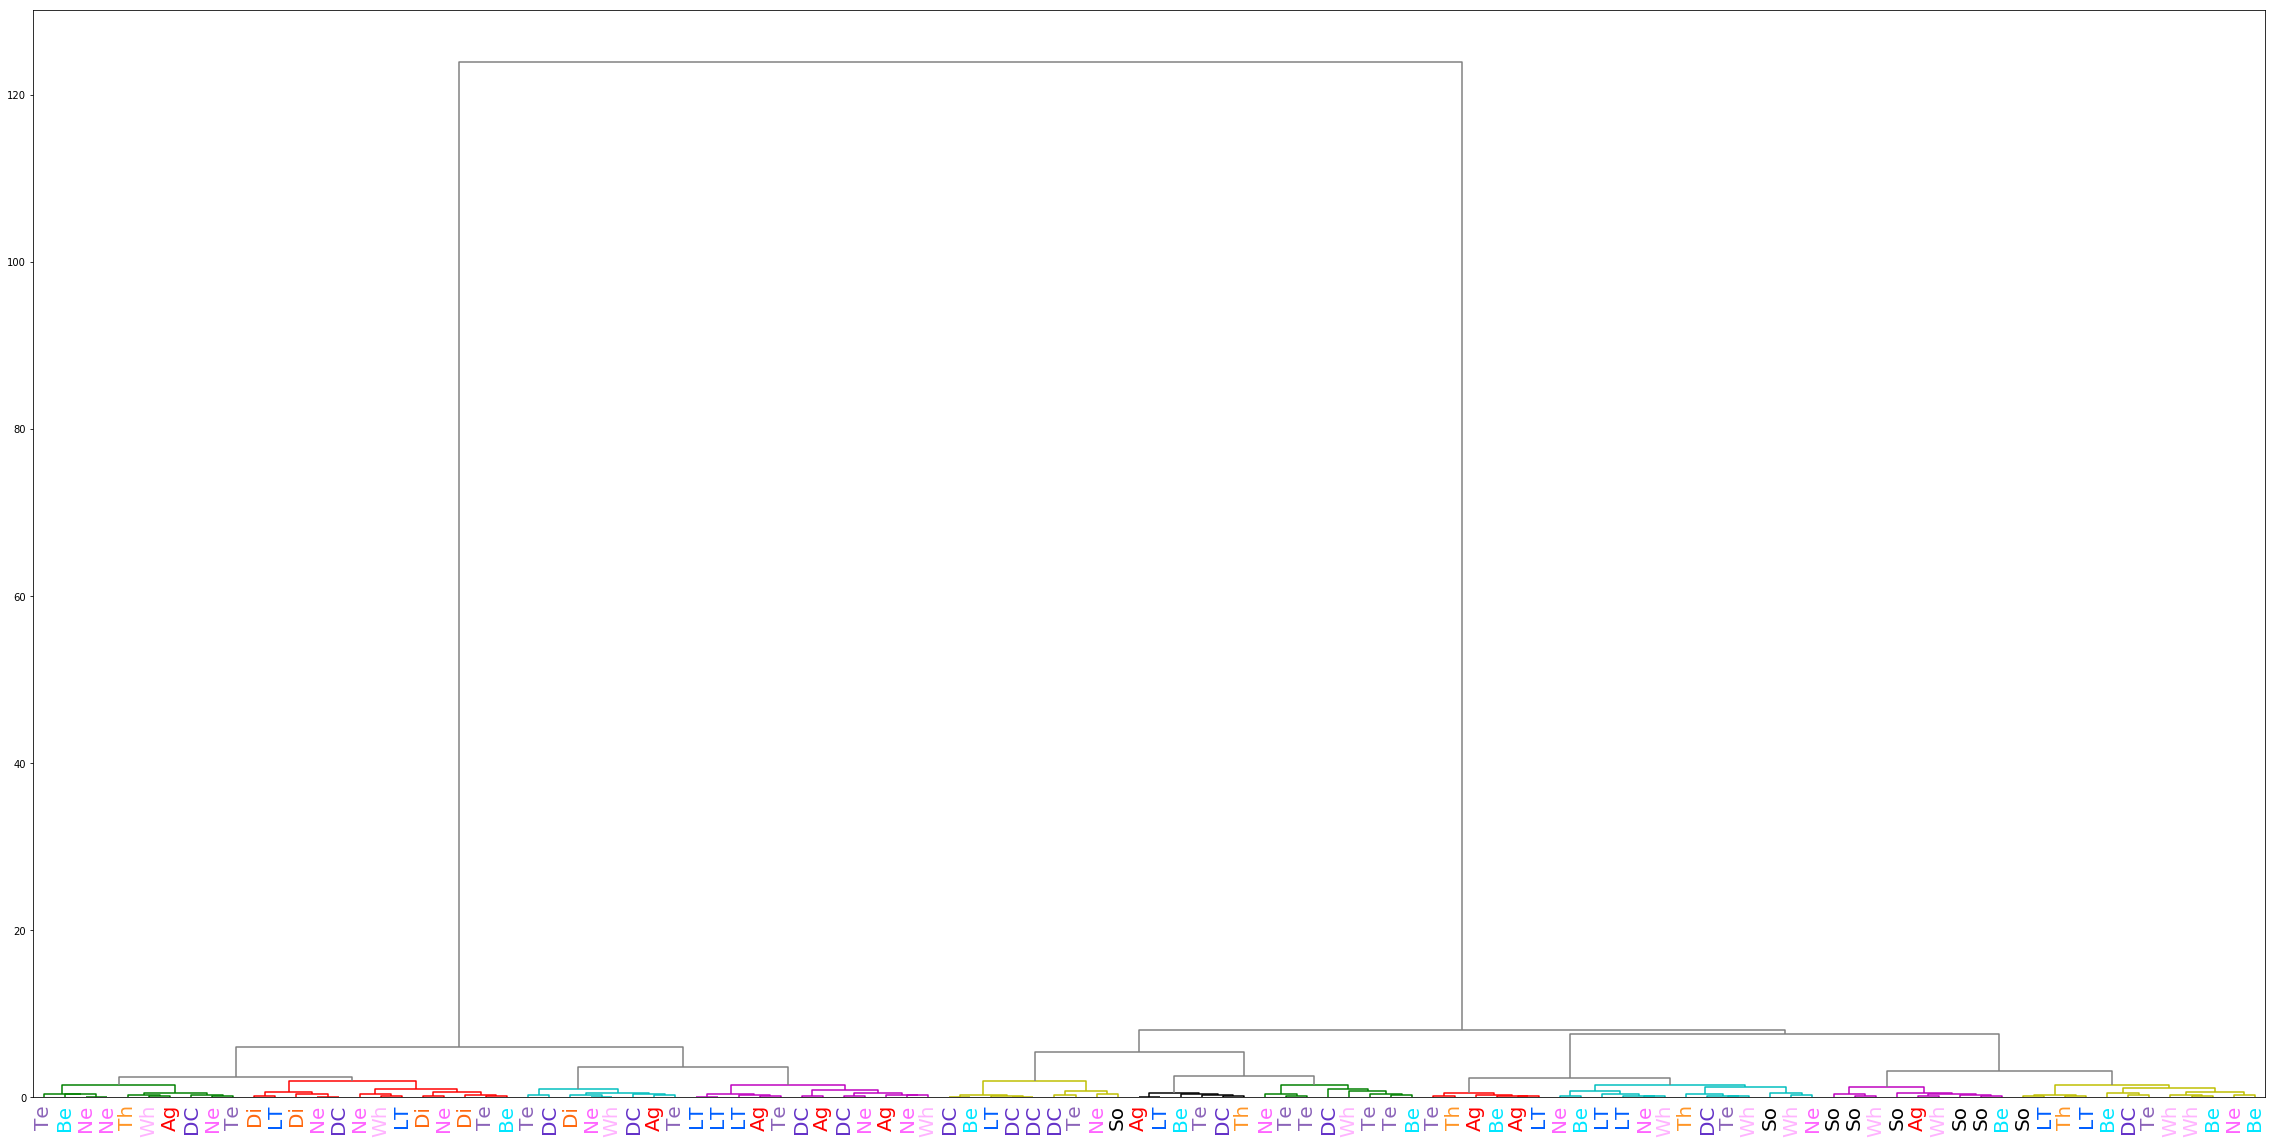

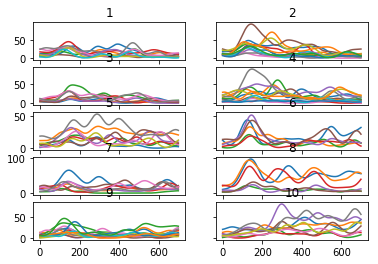

In [9]:
F,ari = cluster_analysis(AMP_ANGLE,dfRelTime['call_type'][:],and_plot=True,use_umap=True)
plot_grouping(PSTH_KDES_first_600,F)

## Discrete Wavelet Transform

In [10]:
# lets do clustering on DWT
maxari = 0
maxwt='db1'
for wt in pywt.wavelist(kind='discrete'):
    (ca,cb) = pywt.dwt(PSTH_KDES_first_600,wt)

    DWT = np.append(ca,cb,1)
    F,ari = cluster_analysis(DWT,dfRelTime['call_type'][:])
    if ari>maxari:
        maxari=ari
        maxwt=wt


-------------
0.054125435098651135
-------------
-------------
0.054125435098651135
-------------
-------------
0.058604735552934765
-------------
-------------
0.055433876577275734
-------------
-------------
0.055433876577275734
-------------
-------------
0.04179006252056598
-------------
-------------
0.040427803615700614
-------------
-------------
0.054125435098651135
-------------
-------------
0.055433876577275734
-------------
-------------
0.058604735552934765
-------------
-------------
0.04179006252056598
-------------
-------------
0.03709403837792933
-------------
-------------
0.055433876577275734
-------------
-------------
0.058604735552934765
-------------
-------------
0.040427803615700614
-------------
-------------
0.055433876577275734
-------------
-------------
0.058604735552934765
-------------
-------------
0.040427803615700614
-------------
-------------
0.04077421838398514
-------------
-------------
0.03923152368314775
-------------
-------------
0.039231523

-------------
0.08228398755639305
-------------


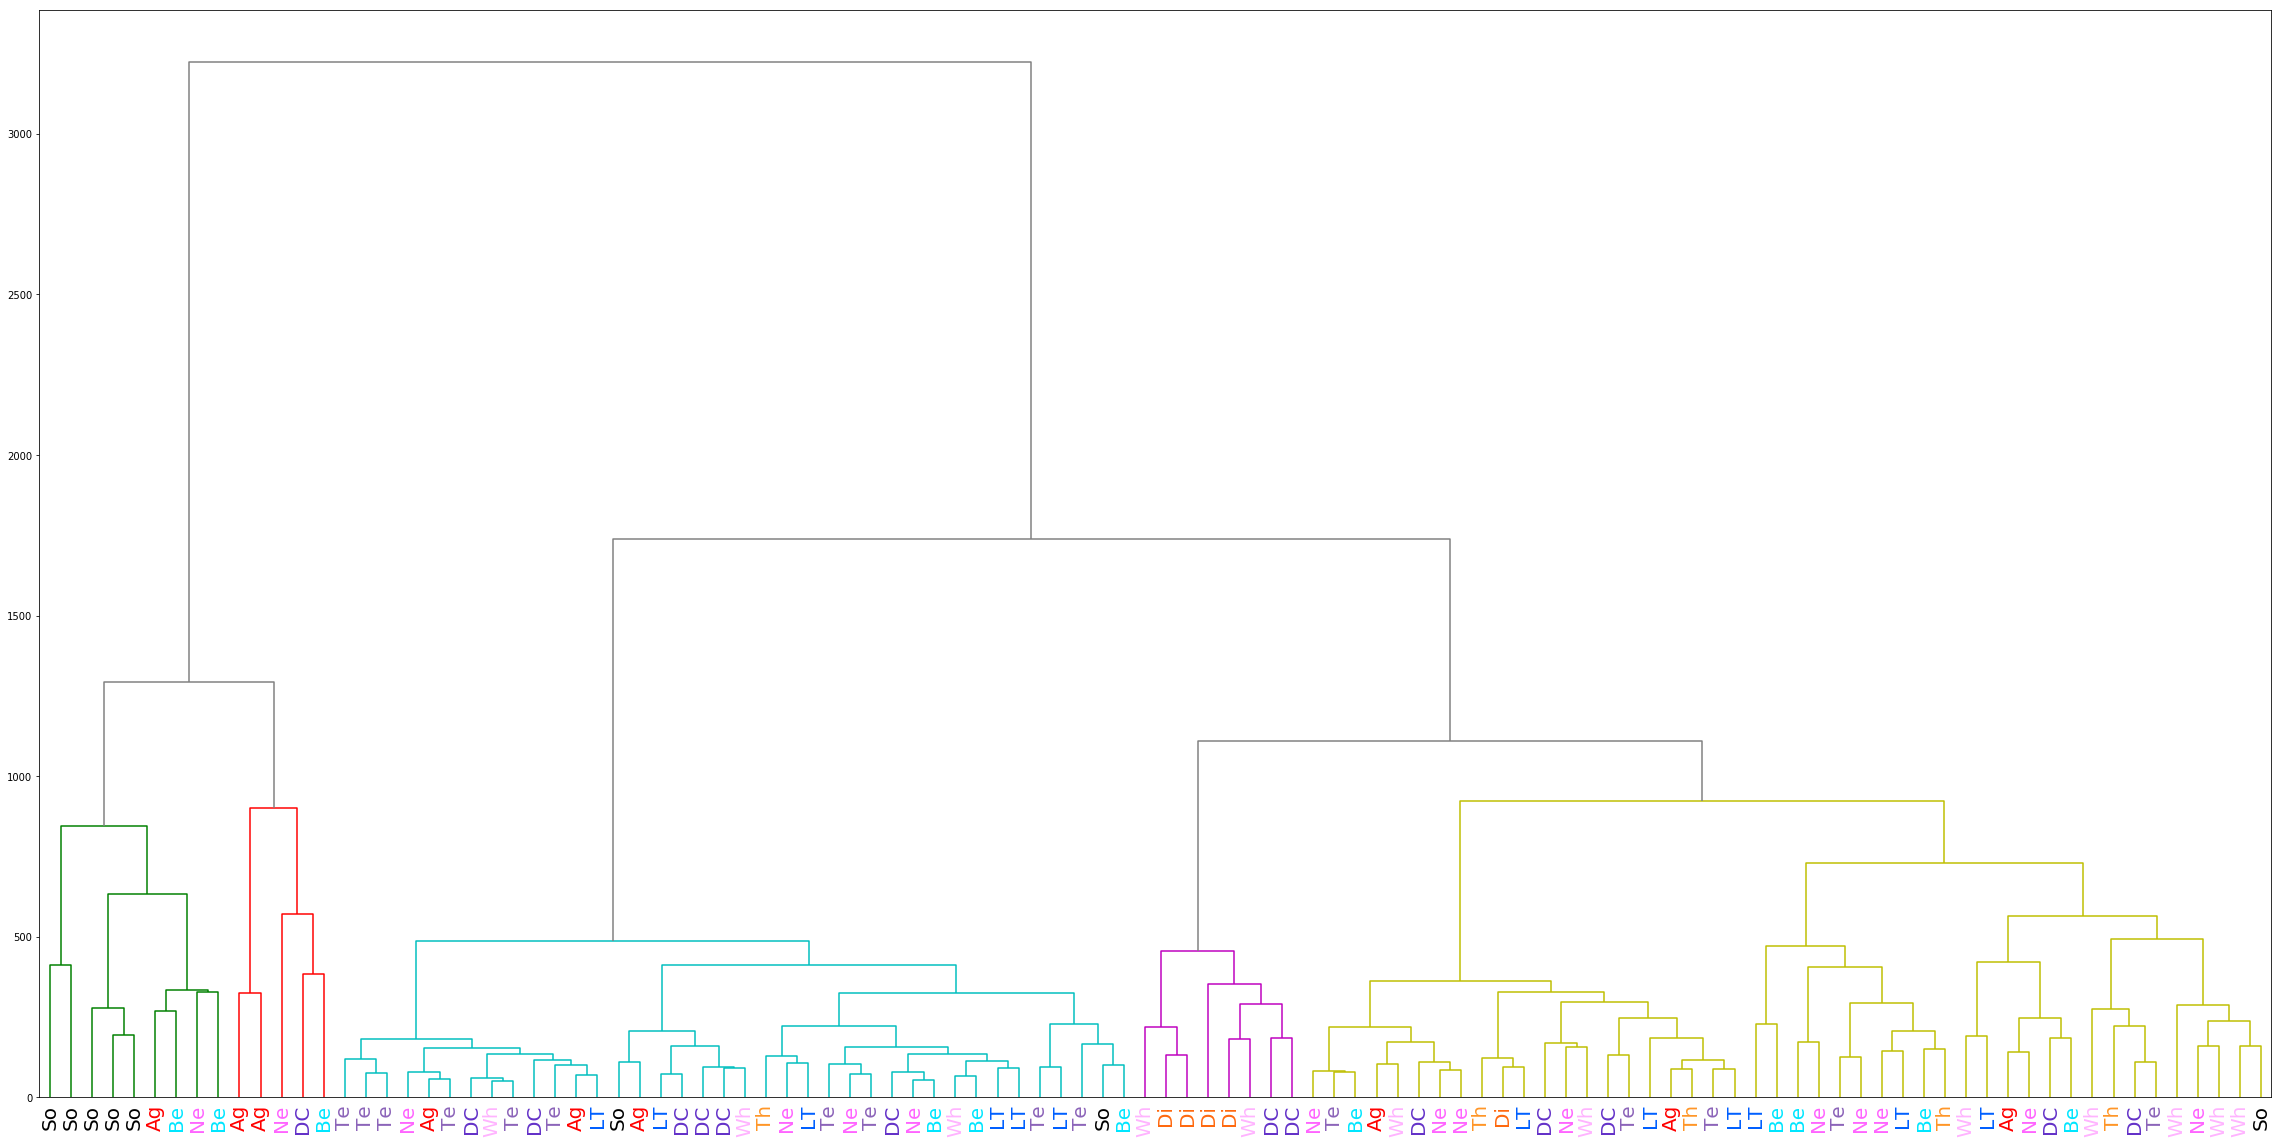

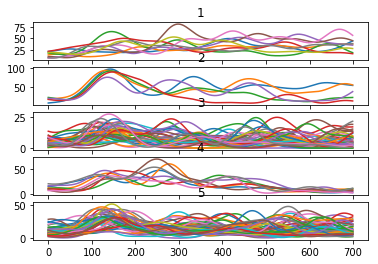

In [11]:
(ca,cb) = pywt.dwt(PSTH_KDES_first_600,maxwt)
DWT = np.append(ca,cb,1)
F,ari = cluster_analysis(DWT,dfRelTime['call_type'][:],and_plot=True)
plot_grouping(PSTH_KDES_first_600,F)

-------------
0.06770619444064196
-------------


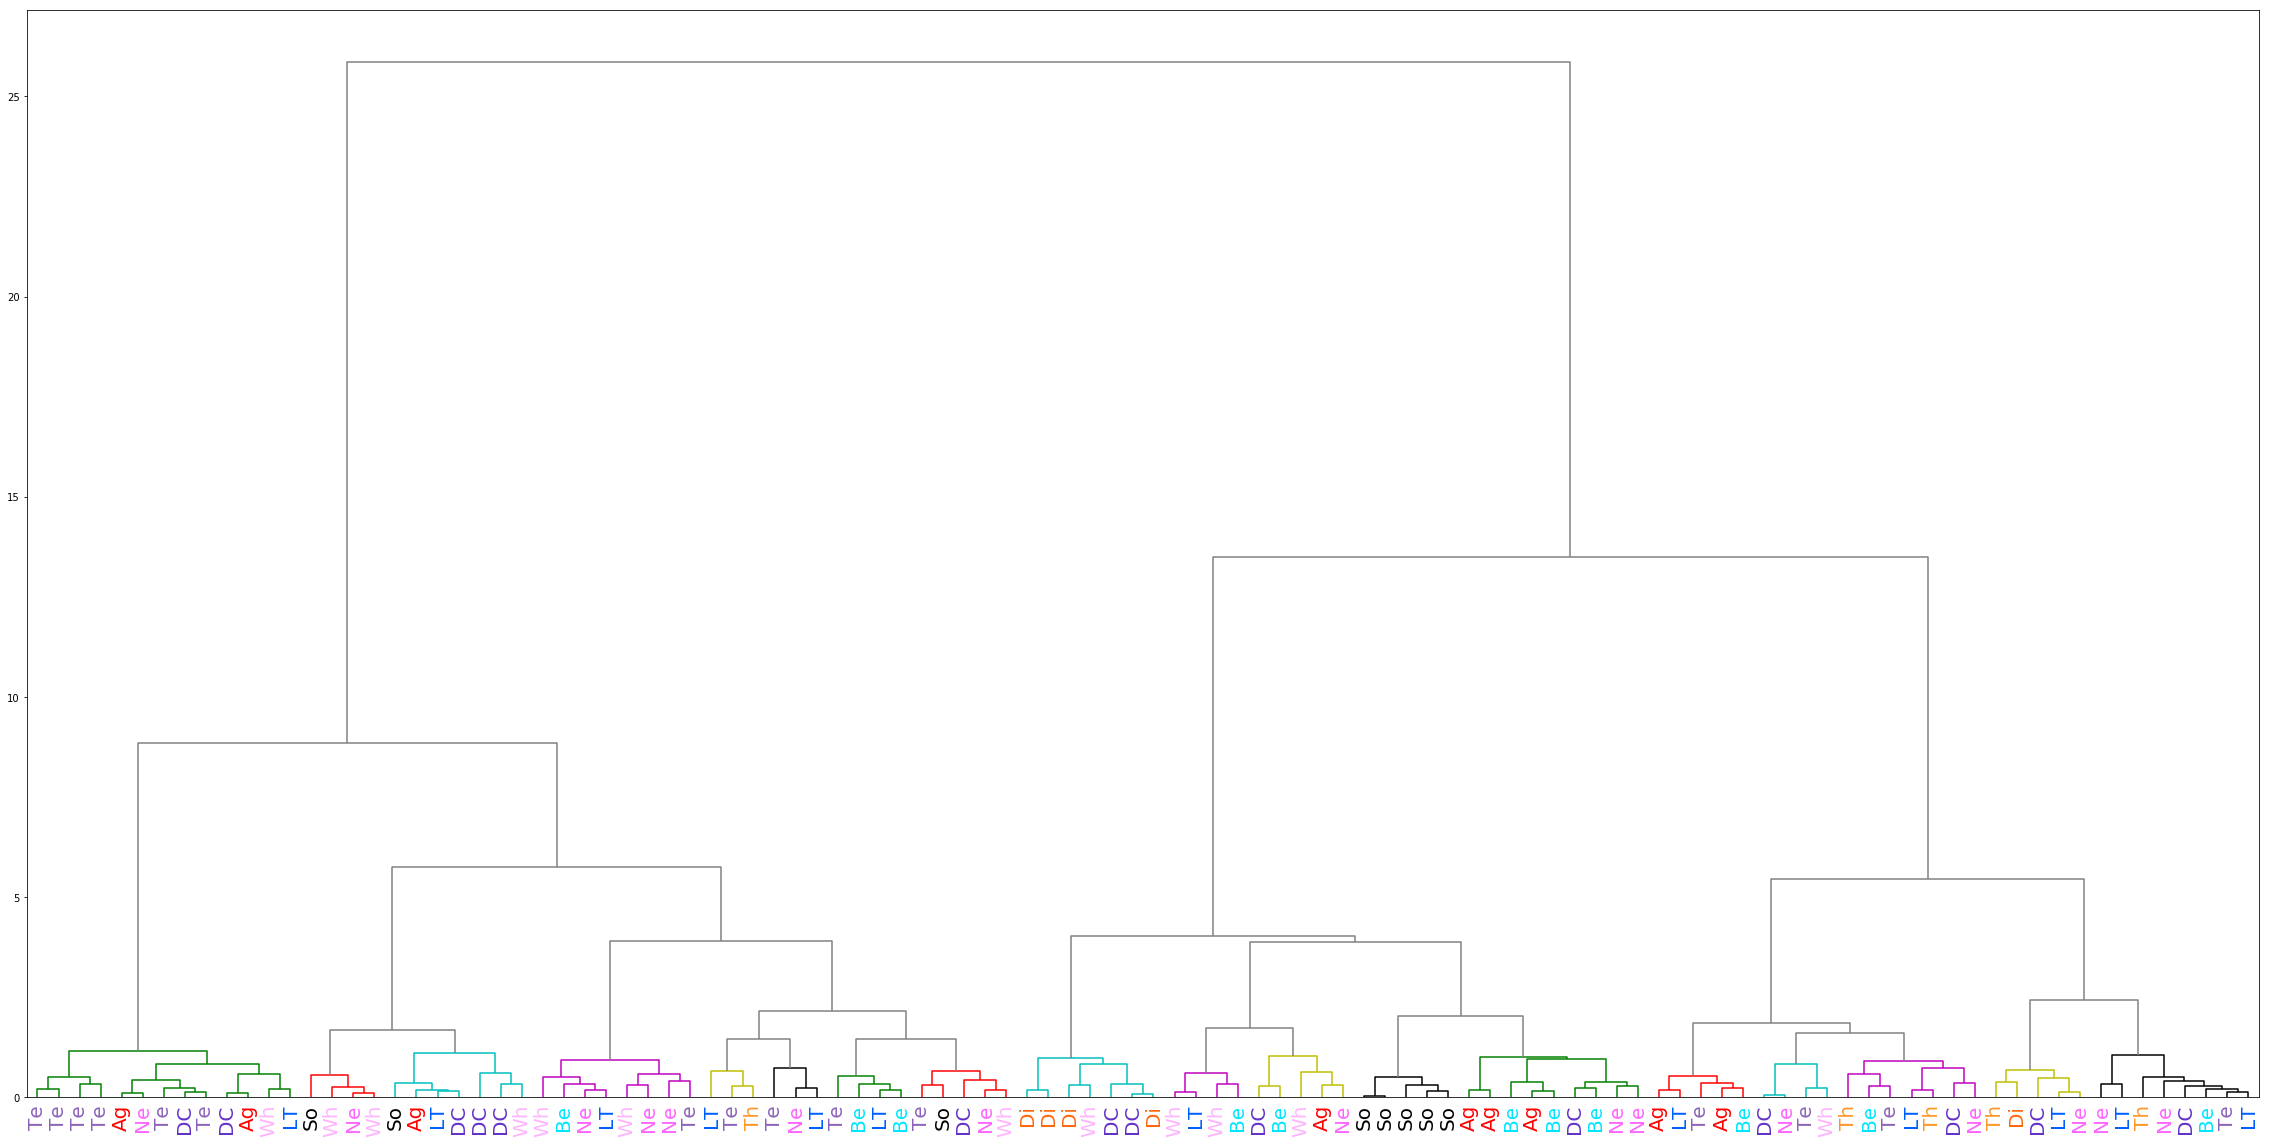

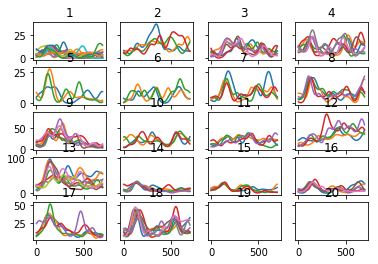

In [12]:
F,ari = cluster_analysis(DWT,dfRelTime['call_type'][:],and_plot=True,use_umap=True)
plot_grouping(PSTH_KDES_first_600,F)

## Agglomerative

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
numcomps = 20
nfiles = 5
MesPCS = dict()
#MesPCS=np.ones((nfiles,130,numcomps))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(PSTH_KDES_first_600[:,:])

In [ ]:
plt.figure(figsize= (40,20))

plot_dendrogram(model,leaf_rotation=90.,
         leaf_font_size=20.,labels = np.array(dfRelTime['call_type']))
callColor = {
        'Be':(0/255.0, 230/255.0, 255/255.0),
        'LT':(0/255.0, 95/255.0, 255/255.0),
        'Tu':(255/255.0, 200/255.0, 65/255.0),
        'Th':(255/255.0, 150/255.0, 40/255.0),
        'Di':(255/255.0, 105/255.0, 15/255.0),
        'Ag':(255/255.0, 0/255.0, 0/255.0),
        'Wh':(255/255.0, 180/255.0, 255/255.0),
        'Ne':(255/255.0, 100/255.0, 255/255.0),
        'Te':(140/255.0, 100/255.0, 185/255.0),
        'DC':(100/255.0, 50/255.0, 200/255.0),
        'song':(0, 0, 0),
        'So':(0,0,0),}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for t in xlbls:
    t.set_color(callColor[t.get_text()])
plt.show()

In [ ]:
ncs=int(max(F)/5+.5)
fig, ax = plt.subplots(5, ncs, sharex='col', sharey='row')
for r in range(5):
    for c in range(ncs):
        gid = r*ncs+c%ncs+1
        ax_tmp = ax[r,c] if ncs > 1 else ax[r]
        ax_tmp.set_title(gid)
        for j in np.where(F==gid)[0]:
            ax_tmp.plot(PSTH_KDES_first_600[j,:])  

In [ ]:
def check_waveform(pkl_path, fixed_window=True):
    fileIn = open(pkl_path, 'rb')
    unitInfo = pk.load(fileIn)
    dfAbsTime = pk.load(fileIn)
    dfRelTime = pk.load(fileIn)
    fileIn.close()
    
    # only take data for times we know the call type
    dfRelTime = dfRelTime[dfRelTime["call_type"].astype(bool)]
    pdEphysAndStim = []

    # now go through each playback and find the voc cuts present in the first 600 ms of each playback
    for ind, row in dfRelTime.iterrows():
        sfn = row.file[:-10]
        # get segments associated with this stimulus
        segs = pdsegTable[pdsegTable['stimname'] == sfn]
        if len(segs)==0:
            continue
        if fixed_window:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_win = .5
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            t_start = np.min(segs.start) + t_delay#0.0 #s

            while (segs['start'] >= t_start - t_delay).sum() > 0:
                # first take the s_win long PSTH window
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_start + t_win)
                psth = row.spikeKDE[t_inds]

                # then take all stim that are present in that window (shifted by t_delay)
                stim_inds = np.logical_and(segs['start'] >= t_start - t_delay, segs['start'] < t_start + t_win - t_delay)
                present_stims = np.array(segs.ind[stim_inds])

                #spikerate from spiketimes
                srs = [np.logical_and(sts >= t_start,sts < t_start + t_win).sum() for sts in row.spikeTimes]

                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':present_stims, 
                                       'call_type': row.call_type, 'rate': np.mean(srs)/(t_win), 'maxsr': psth.max()})

                next_stim_inds = segs.start >= t_start + t_win - t_delay
                if next_stim_inds.sum() == 0:
                    break
                t_start = np.min(segs.start[next_stim_inds]) + t_delay
        else:
            #basically i will take all segments in the first 600 ms, if there are more segments, 
            # i will take another window starting at the next segment
            t_after = .05
            t_delay = .01
            # 10 ms after onset of cut, 50 ms after audio off of cut
            for _,seg in segs.iterrows():
                t_start = seg.start + t_delay#0.0 #s
                t_end = seg.end + t_delay + t_after
                t_inds = np.logical_and(row.tKDE >= t_start, row.tKDE < t_end)
                psth = row.spikeKDE[t_inds]
                srs = [np.logical_and(sts >= t_start,sts < t_end).sum() for sts in row.spikeTimes]
                pdEphysAndStim.append({'stimname': sfn, 't_start': t_start,
                                       'psth': psth, 'present_stims':[seg.ind], 
                                       'call_type': row.call_type, 'rate': np.mean(srs)/(t_end - t_start), 'maxsr': psth.max()})
                

    pdStimSegTable = pandas.DataFrame(pdEphysAndStim)
    # now plot rate against umap from audio
    x_y_sr = []
    sr_range = [pdStimSegTable.rate.min(), pdStimSegTable.rate.max()]
    
    for ind,row in pdStimSegTable.iterrows():
        for stim in row.present_stims:
            x_y_sr.append([vocCategoryTable.at[stim,'%s1'%prefix],vocCategoryTable.at[stim,'%s2'%prefix], row.maxsr, row.rate])
    x_y_sr = np.asarray(x_y_sr,dtype=float)
    seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,2])
    plt.figure()
    seaborn.scatterplot(x_y_sr[:,0],x_y_sr[:,1],x_y_sr[:,3])

In [271]:
dfRelTime.micWav

0     [[-9.883215332040507e-05, 0.000455133415222075...
1     [[-2.307024574288441e-05, -0.00027484026527413...
2     [[-0.0005000941152573102, 0.00136302787113185,...
3     [[9.432355308525153e-05, 0.0003460935726165015...
4     [[0.0006696139383315369, 0.0001660738992690369...
5     [[-7.41347751618271e-05, 0.0001776352443694229...
6     [[0.0005420791568755412, -6.207352256781817e-0...
7     [[0.0003340808801650663, -1.8420989036593838e-...
8     [[-0.00048291421318058525, -0.0003318760433197...
9     [[-0.0007296760501862565, -2.4672311782936163e...
10    [[0.0011641152486800976, -0.000447236718177812...
11    [[-0.00014422790145873776, 0.00056065662765503...
12    [[0.0002956825447082423, 9.433805465697276e-05...
13    [[0.00027049819660196484, 0.000119460026741124...
14    [[-0.00022811873245243142, -0.0001273868827820...
15    [[5.616808986674826e-05, -0.000296214570045361...
16    [[-0.0002993146162033611, -0.00070212280559545...
17    [[0.0005645458116532165, -0.00044253426647

In [337]:
for ind,row in summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].iterrows():
    print(row)

bird                                                   ZF7F
site                                  ZF7F_5t_190720_152938
unit                               goodPlayback-e19-c64.pkl
snr                                                 12.0463
zAud                                               0.631916
pAud                                                      0
nTot                                                    664
selInd                                              0.25506
calls              [Ag, DC, Ne, So, Te, Th, Wh, Di, Be, LT]
zcall     [1.0140636355186685, 1.0713286691904917, 0.636...
pcall     [0.047550954536833334, 0.0393636856509334, 0.1...
ncall     [52.0, 82.0, 92.0, 56.0, 91.0, 30.0, 79.0, 32....
Name: 10, dtype: object
bird                                                   ZF7F
site                                  ZF7F_5t_190720_152938
unit                               goodPlayback-e19-c65.pkl
snr                                                  7.5709
zAud            

In [338]:
summary

bird                     site                       unit        snr  \
0    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e11-c1.pkl   4.331624   
1    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e12-c1.pkl   4.535319   
2    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e13-c4.pkl   3.298618   
3    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e13-c5.pkl   4.718718   
4    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e14-c1.pkl   4.562821   
5    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e15-c1.pkl   4.134794   
6    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e16-c1.pkl   5.252661   
7    ZF7F    ZF7F_5t_190720_152938    goodPlayback-e17-c1.pkl   4.644099   
8    ZF7F    ZF7F_5t_190720_152938   goodPlayback-e18-c11.pkl   8.012570   
9    ZF7F    ZF7F_5t_190720_152938   goodPlayback-e18-c12.pkl   5.052138   
10   ZF7F    ZF7F_5t_190720_152938   goodPlayback-e19-c64.pkl  12.046316   
11   ZF7F    ZF7F_5t_190720_152938   goodPlayback-e19-c62.pkl   4.597895   
12   ZF7F    ZF7F_5t_190720_152938   goodPlayback-e19-c65.pkl   7.570900   
13   ZF7F    ZF7F_5t_190720_152938    goodPlayback-e20-c1.pkl   4.559751   
14   ZF7F    ZF7F_5t_190720_152938    goodPlayback-e21-c1.pkl   4.378903   
15   ZF7F    ZF7F_5t_190720_152938   goodPlayback-e22-c19.pkl   5.341993   
16   ZF7F    ZF7F_5t_190720_152938     goodPlayback-e8-c1.pkl   4.490756   
17   ZF7F    ZF7F_5t_190720_152938     goodPlayback-e9-c8.pkl   4.675362   
18   ZF7F    ZF7F_5t_190720_152938     goodPlayback-e9-c7.pkl   5.359690   
19   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e13-c10.pkl   4.616716   
20   ZF7F  ZF7F_8_5t_190809_133540    goodPlayback-e14-c2.pkl   4.905414   
21   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e16-c36.pkl   5.416767   
22   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e16-c38.pkl   4.364770   
23   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e16-c40.pkl   4.745983   
24   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e17-c31.pkl   7.106701   
25   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e17-c29.pkl   5.143243   
26   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e17-c28.pkl   4.796112   
27   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e18-c14.pkl   6.037626   
28   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e18-c13.pkl   4.906864   
29   ZF7F  ZF7F_8_5t_190809_133540   goodPlayback-e19-c33.pkl   5.197789   
..    ...                      ...                        ...        ...   
700  ZF4F    ZF4F_6t_190616_142033   goodPlayback-e21-c46.pkl   5.976540   
701  ZF4F    ZF4F_6t_190616_142033   goodPlayback-e21-c44.pkl   5.285084   
702  ZF4F  ZF4F_8_5t_190621_100019   goodPlayback-e10-c92.pkl   8.134097   
703  ZF4F  ZF4F_8_5t_190621_100019   goodPlayback-e10-c90.pkl   7.728941   
704  ZF4F  ZF4F_8_5t_190621_100019   goodPlayback-e10-c93.pkl   4.915227   
705  ZF4F  ZF4F_8_5t_190621_100019  goodPlayback-e11-c104.pkl  11.257588   
706  ZF4F  ZF4F_8_5t_190621_100019  goodPlayback-e11-c105.pkl   6.419096   
707  ZF4F  ZF4F_8_5t_190621_100019  goodPlayback-e18-c117.pkl  13.410840   
708  ZF4F  ZF4F_8_5t_190621_100019  goodPlayback-e18-c122.pkl   5.092752   
709  ZF4F  ZF4F_8_5t_190621_100019   goodPlayback-e19-c40.pkl   6.767867   
710  ZF4F  ZF4F_8_5t_190621_100019   goodPlayback-e21-c76.pkl   7.003511   
711  ZF4F   ZF4F_6_5_190618_110932    goodPlayback-e18-c1.pkl   6.905778   
712  ZF4F    ZF4F_7t_190619_095313    goodPlayback-e10-c1.pkl   4.993431   
713  ZF4F    ZF4F_7t_190619_095313    goodPlayback-e11-c1.pkl   6.074238   
714  ZF4F    ZF4F_7t_190619_095313    goodPlayback-e12-c1.pkl   5.086608   
715  ZF4F    ZF4F_7t_190619_095313    goodPlayback-e13-c1.pkl   4.039645   
716  ZF4F    ZF4F_7t_190619_095313   goodPlayback-e16-c54.pkl   6.485549   
717  ZF4F    ZF4F_7t_190619_095313   goodPlayback-e16-c55.pkl   5.508947   
718  ZF4F    ZF4F_7t_190619_095313   goodPlayback-e19-c50.pkl   4.985538   
719  ZF4F    ZF4F_7t_190619_095313   goodPlayback-e19-c49.pkl   8.688466   
720  ZF4F    ZF4F_7t_190619_095313    goodPlayback-e2

In [339]:
for ind,row in summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].iterrows():
    pkl_path = "/auto/zdrive/lthomas/goodpkls/birds/%s/%s/%s"%(row['bird'],row['site'],row['unit'])
    print(pkl_path)
    fileIn = open(pkl_path, 'rb')
    unitInfo = pk.load(fileIn)
    dfAbsTime = pk.load(fileIn)
    dfRelTime = pk.load(fileIn)
    fileIn.close()
    break

/auto/zdrive/lthomas/goodpkls/birds/ZF7F/ZF7F_5t_190720_152938/goodPlayback-e19-c64.pkl


In [341]:
dfStimMultiUnit = []
for ind,row in summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].iterrows():
    pkl_path = "/auto/zdrive/lthomas/goodpkls/birds/%s/%s/%s"%(row['bird'],row['site'],row['unit'])
    print(pkl_path)
    fileIn = open(pkl_path, 'rb')
    unitInfo = pk.load(fileIn)
    dfAbsTime = pk.load(fileIn)
    dfRelTime = pk.load(fileIn)
    fileIn.close()
    dfStimMultiUnit.append({"bird": row['bird'], 'site':})

file relation_short call_type  start_time  \
0     BlaBla0506_MAF_Ne_5-2-3_fs25k.wav           BlaB        Ne     6.93176   
1         BlaLbl8026_FAS_Ag_2_fs25k.wav           BlaL        Ag    14.80400   
2     LblBla4548_MAF_Ne_9-7-5_fs25k.wav           LblB        Ne    21.02672   
3         LblGre0001_UCF_Be_1_fs25k.wav           LblG        Be    29.35972   
4     LblBla4548_MAF_Wh_9-3-1_fs25k.wav           LblB        Wh    36.04536   
5     WhiWhi1415_FAF_Th_8-7-6_fs25k.wav           WhiW        Th    43.30960   
6         BlaLbl8026_FAS_Di_1_fs25k.wav           BlaL        Di    50.35916   
7     GraLbl0457_MAS_Te_7-8-1_fs25k.wav           GraL        Te    56.44796   
8         GraLbl0457_MAS_So_0_fs25k.wav           GraL        So    62.61776   
9         LblGre0000_UCF_Be_0_fs25k.wav           LblG        Be    71.11176   
10    LblGre0001_UCF_LT_5-4-6_fs25k.wav           LblG        LT    77.88688   
11        BlaBla0506_MAF_So_1_fs25k.wav           BlaB        So    86.48228   
12        LblBlu2028_MCS_Be_2_fs25k.wav           LblB        Be    94.31800   
13        BlaLbl8026_FAS_Di_2_fs25k.wav           BlaL        Di   100.40864   
14    WhiWhi1415_FAF_Te_5-3-1_fs25k.wav           WhiW        Te   105.24740   
15        GraLbl0457_MAS_Di_0_fs25k.wav           GraL        Di   112.94736   
16        GraLbl0457_MAS_Ag_0_fs25k.wav           GraL        Ag   118.99184   
17    LblBlu2028_MCS_LT_7-6-2_fs25k.wav           LblB        LT   124.88072   
18    GraLbl0457_MAS_Wh_4-9-1_fs25k.wav           GraL        Wh   132.95620   
19    LblGre0000_UCF_LT_6-7-9_fs25k.wav           LblG        LT   139.93512   
20    BlaLbl8026_FAS_Ne_2-6-9_fs25k.wav           BlaL        Ne   148.35200   
21    WhiWhi1415_FAF_Wh_2-3-1_fs25k.wav           WhiW        Wh   156.37688   
22    BlaBla0506_MAF_Wh_7-9-5_fs25k.wav           BlaB        Wh   164.14784   
23        GraLbl0457_MAS_Di_1_fs25k.wav           GraL        Di   172.26724   
24    LblBlu2028_MCS_LT_9-4-8_fs25k.wav           LblB        LT   176.77760   
25    GraLbl0457_MAS_Te_5-2-6_fs25k.wav           GraL        Te   185.26512   
26    LblBla4548_MAF_DC_5-4-9_fs25k.wav           LblB        DC   194.13348   
27        LblBla4548_MAF_So_1_fs25k.wav           LblB        So   201.34784   
28        LblBlu2028_MCS_Be_1_fs25k.wav           LblB        Be   208.95972   
29    LblBla4548_MAF_Te_2-8-7_fs25k.wav           LblB        Te   214.17032   
..                                  ...            ...       ...         ...   
716       BlaBla0506_MAF_So_2_fs25k.wav           BlaB        So  5174.92504   
717       LblBla4548_MAF_So_1_fs25k.wav           LblB        So  5182.99768   
718   LblBla4548_MAF_Ne_8-6-2_fs25k.wav           LblB        Ne  5191.28952   
719       LblGre0000_UCF_Be_0_fs25k.wav           LblG        Be  5197.76904   
720       LblBlu1630_FCS_Be_2_fs25k.wav           LblB        Be  5204.04636   
721   BlaBla0506_MAF_Th_5-3-4_fs25k.wav           BlaB        Th  5210.06496   
722       GraLbl0457_MAS_So_1_fs25k.wav           GraL        So  5216.47116   
723   WhiWhi1415_FAF_Wh_2-3-1_fs25k.wav           WhiW        Wh  5224.81020   
724   GraLbl0457_MAS_Wh_6-7-3_fs25k.wav           GraL        Wh  5233.61732   
725   BlaLbl8026_FAS_DC_1-4-6_fs25k.wav           BlaL        DC  5243.74380   
726   LblBla4548_MAF_DC_5-4-9_fs25k.wav           LblB        DC  5252.36476   
727   BlaBla0506_MAF_DC_7-3-6_fs25k.wav           BlaB        DC  5260.74236   
728   GraLbl0457_MAS_Te_7-8-1_fs25k.wav           GraL        Te  5267.02392   
729   GraLbl0457_MAS_DC_7-3-5_fs25k.wav           GraL        DC  5273.42100   
730       LblGre0001_UCF_Be_0_fs25k.wav           LblG        Be  5280.65336   
731   GraLbl0457_MAS_DC_1-4-2_fs25k.wav           GraL        DC  5287.34840   
732   LblBlu2028_MCS_LT_9-4-8_fs25k.wav           LblB        LT  5294.69564   
733   BlaBla0506_MAF_Ne_8-7-4_fs25k.wav           BlaB        Ne  5301.17356   
734       GraLbl0457_MAS_So_2_fs25k

In [343]:
np.unique(summary[(summary['zAud'] > .5)&(summary['selInd'] > .1)].site)

array(['ZF4F_2t_190611_160843', 'ZF4F_2t_190612_101201',
       'ZF4F_2t_190612_134337', 'ZF4F_2t_190613_101015',
       'ZF4F_3t_190613_150928', 'ZF4F_5t_190615_114154',
       'ZF4F_5t_190616_102456', 'ZF4F_6_5_190618_110932',
       'ZF4F_6t_190616_142033', 'ZF4F_7t_190619_095313',
       'ZF4F_8_5t_190621_100019', 'ZF5M_10_5t_190703_133641',
       'ZF5M_10t_190702_095313', 'ZF5M_11t_190704_100420',
       'ZF5M_11t_190704_121850', 'ZF5M_7t_190625_154417',
       'ZF5M_8t_190627_132428', 'ZF5M_9t_190630_100846',
       'ZF6M_10_5t_190808_102150', 'ZF6M_2t_190716_085010',
       'ZF6M_6_5t_190719_094702', 'ZF6M_7_5t_190723_100723',
       'ZF6M_7_5t_190723_141539', 'ZF6M_8t_190725_105432',
       'ZF6M_9_5t_190805_102553', 'ZF6M_9_5t_190805_130046',
       'ZF7F_4_5t_190718_091732', 'ZF7F_5_5t_190722_121506',
       'ZF7F_5t_190720_152938', 'ZF7F_7t_190806_115742',
       'ZF7F_8_5t_190809_133540'], dtype=object)